# <center>Regressão Linear - Previsão de IMC

 Legendas:
   * <code style="color:green">Teoria/Instruções</code>
   * <code style="color:purple">Comentários</code>
   * <code style="color:red">Dúvidas a serem esclarecidas</code>

### <center>Importando Bibliotecas

In [185]:
import pandas as pd # importando a biblioteca de manipulação de dados
import statsmodels.api as sm # biblioteca para a regressão logística
import numpy as np # biblioteca para calculo
from matplotlib import pyplot as plt # importando a biblioteca de visualização de dados 
import seaborn as sns# importando a biblioteca de visualização de dados 
from tabulate import tabulate # biblioteca para estilizar tabelas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # funções de erro
from statsmodels.stats.outliers_influence import variance_inflation_factor # funções para calcular o vif
import scipy.stats as stats # biblioteca para modelagem
import pylab # biblioteca para o qqplot
from statsmodels.stats.diagnostic import het_breuschpagan # função para o teste de breusch-pagan
from scipy.stats import shapiro # teste de normalidade
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

### <center>Funções para seleção de variáveis utilizando métodos backward, forward e stepwise:

In [186]:
# Esta função realiza uma seleção forward stepwise com base no p-valor das variáveis independentes.
# A cada passo, adiciona a variável independente com o menor p-valor ao modelo, desde que o p-valor 
# seja menor que o nível de significância especificado.
# Parâmetros:
# - var_dependente: Nome da variável dependente.
# - var_independente: Lista de variáveis independentes a serem avaliadas.
# - base: Conjunto de dados contendo as variáveis dependentes e independentes.
# - signif: Nível de significância para a inclusão das variáveis (por exemplo, 0.05).
# Retorna: DataFrame contendo as variáveis selecionadas e seus respectivos p-valores.
# criada por Mateus Rocha - time ASN.Rocks

def selecionar_pvalor_forward(var_dependente, var_independente, base, signif):

    preditoras = []
    pvalor_preditoras = []
    Y = base[var_dependente]
    while True and var_independente != [] :
        lista_pvalor = []
        lista_variavel = []
        for var in var_independente:
            X = sm.add_constant(base[ [var] +  preditoras ])
            
            modelo = sm.OLS(Y,X).fit()
            
            if( preditoras == []):
    
                pvalor = modelo.pvalues[1]
                variavel = modelo.pvalues.index[1]
            
            else:
                pvalor = modelo.pvalues.drop(preditoras)[1]
                variavel = modelo.pvalues.drop(preditoras).index[1]
                
            lista_pvalor.append(pvalor)
            lista_variavel.append(variavel)          
        
        if( lista_pvalor[ np.argmin(lista_pvalor) ] < signif ):
            preditoras.append( lista_variavel[np.argmin(lista_pvalor)] )
            pvalor_preditoras.append(lista_pvalor[ np.argmin(lista_pvalor) ])
            var_independente.remove( lista_variavel[ np.argmin(lista_pvalor)] )
        else:
            break
    info_final = pd.DataFrame({ 'var': preditoras, 'pvalor': pvalor_preditoras})
    return info_final

# Exemplo de uso
# colunas_pvalor = selecionar_pvalor_forward(var_dependente='bodyfat', var_independente=X.columns.to_list(), base=Bodyfat, signif=0.05)
# colunas_pvalor

In [187]:
# Esta função realiza uma seleção forward stepwise com base no critério de informação de Akaike (AIC).
# A cada passo, adiciona a variável independente que minimiza o AIC ao modelo.
# Parâmetros:
# - var_dependente: Nome da variável dependente.
# - var_independente: Lista de variáveis independentes a serem avaliadas.
# - base: Conjunto de dados contendo as variáveis dependentes e independentes.
# Retorna: DataFrame contendo as combinações de variáveis selecionadas e seus respectivos AICs, 
# ordenados do menor para o maior AIC.
# criada por Mateus Rocha - time ASN.Rocks

def selecionar_aic_forward(var_dependente, var_independente, base):
    
    preditoras = []
    aic_preditoras = []
    Y = base[var_dependente]
    lista_final = []
    aic_melhor = float('inf')
    
    while True and var_independente != []:
        lista_aic = []
        lista_variavel = []
        lista_modelos =[]
        if(var_independente == []):
            break
        for var in var_independente:
            X = sm.add_constant(base[ [var] +  preditoras ])
            aic = sm.OLS(Y,X).fit().aic
            variavel = var
                
            lista_aic.append(aic)
            
            lista_variavel.append(var)
            
            lista_modelos.append( [var] +  preditoras )
            
        if( lista_aic[ np.argmin(lista_aic) ] < aic_melhor ):
            
            lista_final.append(lista_modelos[ np.argmin(lista_aic)]  )
            
            preditoras.append( lista_variavel[np.argmin(lista_aic)] )
            
            aic_preditoras.append(lista_aic[ np.argmin(lista_aic) ])
            
            var_independente.remove( lista_variavel[ np.argmin(lista_aic)] )
            
            aic_melhor = lista_aic[ np.argmin(lista_aic) ] 
            
        else:
            break
        
    info_final = pd.DataFrame({ 'var': lista_final, 'aic': aic_preditoras}).sort_values(by = 'aic')
    return info_final

# Exemplo de uso
# colunas_aic = selecionar_aic_forward(var_dependente='bodyfat', var_independente=X.columns.to_list(), base=Bodyfat)
# colunas_aic

In [188]:
# Esta função realiza uma seleção forward stepwise com base no critério de informação bayesiano (BIC).
# A cada passo, adiciona a variável independente que minimiza o BIC ao modelo.
# Parâmetros:
# - var_dependente: Nome da variável dependente.
# - var_independente: Lista de variáveis independentes a serem avaliadas.
# - base: Conjunto de dados contendo as variáveis dependentes e independentes.
# Retorna: DataFrame contendo as combinações de variáveis selecionadas e seus respectivos BICs, 
# ordenados do menor para o maior BIC.
# criada por Mateus Rocha - time ASN.Rocks

def selecionar_bic_forward(var_dependente, var_independente, base):
    
    preditoras = []
    bic_preditoras = []
    Y = base[var_dependente]
    lista_final = []
    bic_melhor = float('inf')
    
    while True and var_independente != []:
        lista_bic = []
        lista_variavel = []
        lista_modelos =[]
        if(var_independente == []):
            break
        for var in var_independente:
            X = sm.add_constant(base[ [var] +  preditoras ])
            bic = sm.OLS(Y,X).fit().bic
            variavel = var
                
            lista_bic.append(bic)
            
            lista_variavel.append(var)
            
            lista_modelos.append( [var] +  preditoras )
            
        if( lista_bic[ np.argmin(lista_bic) ] < bic_melhor ):
            
            lista_final.append(lista_modelos[ np.argmin(lista_bic)]  )
            
            preditoras.append( lista_variavel[np.argmin(lista_bic)] )
            
            bic_preditoras.append(lista_bic[ np.argmin(lista_bic) ])
            
            var_independente.remove( lista_variavel[ np.argmin(lista_bic)] )
            
            aic_melhor = lista_bic[ np.argmin(lista_bic) ] 
            
        else:
            break
        
    info_final = pd.DataFrame({ 'var': lista_final, 'bic': bic_preditoras}).sort_values(by = 'bic')
    return info_final

# Exemplo de uso
# colunas_bic = selecionar_bic_forward(var_dependente='bodyfat', var_independente=X.columns.to_list(), base=Bodyfat)
# colunas_bic

In [189]:
# Esta função realiza uma seleção backward stepwise com base no p-valor das variáveis independentes.
# A cada passo, remove a variável independente com o maior p-valor do modelo, 
# desde que seja maior que o nível de significância especificado.
# Parâmetros:
# - var_dependente: Nome da variável dependente.
# - var_independente: Lista de variáveis independentes a serem avaliadas.
# - base: Conjunto de dados contendo as variáveis dependentes e independentes.
# - signif: Nível de significância para a remoção das variáveis (por exemplo, 0.05).
# Retorna: DataFrame contendo as variáveis restantes após a seleção backward.
# criada por Mateus Rocha - time ASN.Rocks

def selecionar_pvalor_backward(var_dependente, var_independente, base, signif):
    Y = base[var_dependente]
    
    while True and var_independente != []:
        
        X_geral = sm.add_constant(base[var_independente])
        
        modelo = sm.OLS(Y,X_geral).fit()
        
        pvalor_geral = modelo.pvalues
        
        variavel_geral = modelo.pvalues.index
        
        if(pvalor_geral[ np.argmax(pvalor_geral) ] > signif ):
            var_independente.remove( variavel_geral[ np.argmax(pvalor_geral) ] )
        else:
            break
    
    
    
    info_final = pd.DataFrame({ 'var': var_independente})
    return info_final

# Exemplo de uso
# colunas_pvalor_back = selecionar_pvalor_backward(var_dependente='bodyfat', var_independente=X.columns.to_list(), base=Bodyfat, signif=0.05)
# colunas_pvalor_back

In [190]:
# Esta função realiza uma seleção backward stepwise com base no critério de informação de Akaike (AIC).
# A cada passo, remove a variável que minimiza o AIC, desde que a remoção resulte em um AIC menor do que o modelo atual.
# Parâmetros:
# - var_dependente: Nome da variável dependente.
# - var_independente: Lista de variáveis independentes a serem avaliadas.
# - base: Conjunto de dados contendo as variáveis dependentes e independentes.
# Retorna: DataFrame contendo as combinações de variáveis selecionadas e seus respectivos AICs, 
# ordenados do menor para o maior AIC.
# criada por Mateus Rocha - time ASN.Rocks

def selecionar_aic_backward(var_dependente, var_independente, base):
    Y = base[var_dependente]
    
    preditoras_finais = []
    
    aic_final = []
    
    while True and var_independente != []:
        
        lista_aic = []
        lista_preditoras = []

        X_geral = sm.add_constant(base[var_independente])
        
        aic_geral = sm.OLS(Y,X_geral).fit().aic
    
        aic_final.append(aic_geral)
        
        preditoras_finais.append(base[var_independente].columns.to_list())
        
        for var in var_independente:
            
            lista_variaveis = var_independente.copy()
            lista_variaveis.remove(var)
            
            X = sm.add_constant(base[ lista_variaveis ])
            aic = sm.OLS(Y,X).fit().aic    
            
            lista_aic.append(aic)
            
            lista_preditoras.append(var)
            
        if(lista_aic[ np.argmin(lista_aic) ] < aic_geral ):
            var_independente.remove( lista_preditoras[ np.argmin(lista_aic) ] )
            
        else:
            break
    
    
    info_final = pd.DataFrame({ 'var': preditoras_finais, 'aic':aic_final }).sort_values(by = 'aic')
    return info_final

# Exemplo de uso
# colunas_aic_back = selecionar_aic_backward(var_dependente='bodyfat', var_independente=X.columns.to_list(), base=Bodyfat)
# colunas_aic_back

In [191]:
# Esta função realiza uma seleção backward stepwise com base no critério de informação bayesiano (BIC).
# A cada passo, remove a variável que minimiza o BIC, desde que a remoção resulte em um BIC menor do que o modelo atual.
# Parâmetros:
# - var_dependente: Nome da variável dependente.
# - var_independente: Lista de variáveis independentes a serem avaliadas.
# - base: Conjunto de dados contendo as variáveis dependentes e independentes.
# Retorna: DataFrame contendo as combinações de variáveis selecionadas e seus respectivos BICs, 
# ordenados do menor para o maior BIC.
# criada por Mateus Rocha - time ASN.Rocks

def selecionar_bic_backward(var_dependente, var_independente, base):
    Y = base[var_dependente]
    
    preditoras_finais = []
    
    bic_final = []
    
    while True and var_independente != []:
        
        lista_bic = []
        lista_preditoras = []

        X_geral = sm.add_constant(base[var_independente])
        
        bic_geral = sm.OLS(Y,X_geral).fit().bic
    
        bic_final.append(bic_geral)
        
        preditoras_finais.append(base[var_independente].columns.to_list())
        
        for var in var_independente:
            
            lista_variaveis = var_independente.copy()
            lista_variaveis.remove(var)
            
            X = sm.add_constant(base[ lista_variaveis ])
            bic = sm.OLS(Y,X).fit().bic    
            
            lista_bic.append(bic)
            
            lista_preditoras.append(var)
            
        if(lista_bic[ np.argmin(lista_bic) ] < bic_geral ):
            var_independente.remove( lista_preditoras[ np.argmin(lista_bic) ] )
            
        else:
            break
    
    
    info_final = pd.DataFrame({ 'var': preditoras_finais, 'bic':bic_final }).sort_values(by = 'bic')
    return info_final

# Exemplo de uso
# colunas_bic_back = selecionar_bic_backward(var_dependente='bodyfat', var_independente=X.columns.to_list(), base=Bodyfat)
# colunas_bic_back

In [192]:
# Esta função realiza a seleção stepwise de variáveis, usando os métodos forward e backward 
# com base em uma métrica específica (AIC, BIC ou p-valor).
# O processo consiste em primeiro aplicar a seleção forward com a métrica escolhida e, 
# em seguida, a backward, ajustando o modelo até que a diferença entre as métricas seja menor 
# que um valor de tolerância (epsilon).
# Parâmetros:
# - var_dependente: Nome da variável dependente.
# - var_independente: Lista de variáveis independentes a serem avaliadas.
# - base: Conjunto de dados contendo as variáveis dependentes e independentes.
# - metrica: A métrica a ser usada no processo de seleção (pode ser 'aic', 'bic', ou 'pvalor').
# - signif: Nível de significância usado para a seleção por p-valor (padrão 0.05).
# - epsilon: Diferença mínima aceitável entre as métricas forward e backward para parar o processo (padrão 0.0001).
# Retorna: DataFrame contendo as variáveis selecionadas e suas respectivas métricas (AIC, BIC ou p-valor), 
# dependendo da métrica usada.
# criada por Mateus Rocha - time ASN.Rocks

def stepwise( var_dependente , var_independente , base, metrica, signif = 0.05, epsilon = 0.0001):
    
    lista_var = var_independente
    
    metrica_forward = 0
    
    metrica_backward = 0
    
    while True:
    
        if(metrica == 'aic'):
            resultado = selecionar_aic_forward(var_dependente = var_dependente, var_independente = var_independente, base = base)

            if (len(resultado) == 1):
                return resultado
            
            resultado_final = selecionar_aic_backward(var_dependente = var_dependente, var_independente = resultado['var'].to_list()[0], base = base)

            if(len(resultado_final) == 1):
                return resultado_final

            metrica_forward = resultado['aic'].to_list()[0]

            metrica_backward = resultado_final['aic'].to_list()[0]


        elif(metrica == 'bic'):
            resultado = selecionar_bic_forward(var_dependente = var_dependente, var_independente = var_independente, base = base)

            if (len(resultado) == 1):
                return resultado

            resultado_final = selecionar_bic_backward(var_dependente = var_dependente, var_independente = resultado['var'].to_list()[0], base = base)

            if(len(resultado_final) == 1):
                return resultado_final

            metrica_forward = resultado['bic'].to_list()[0]

            metrica_backward = resultado_final['bic'].to_list()[0]

        elif(metrica == 'pvalor'):
            resultado = selecionar_pvalor_forward(var_dependente = var_dependente, var_independente = var_independente, base = base, signif = signif)

            if (len(resultado) == 1):
                return resultado

            resultado_final = selecionar_pvalor_backward(var_dependente = var_dependente, var_independente = resultado['var'].to_list(), base = base, signif = signif)

            if(len(resultado_final) == 1):
                return resultado_final

            return resultado_final

        if( abs(metrica_forward - metrica_backward) < epsilon ):
            break
        else:
            var_independente = set(resultado_final['var'].to_list() + lista_var)

# Exemplo de uso
# colunas_stepwise = stepwise(var_dependente='bodyfat', var_independente=X.columns.to_list(), base=Bodyfat, metrica='aic', signif=0.05)
# colunas_stepwise

In [193]:
# Esta função realiza a seleção de variáveis usando os métodos forward, backward ou stepwise, com base em uma métrica escolhida (AIC, BIC ou p-valor).
# O usuário pode escolher o método de seleção (forward, backward ou both) e a métrica desejada para o critério de inclusão ou exclusão de variáveis.
# Parâmetros:
# - var_dependente: Nome da variável dependente.
# - var_independente: Lista de variáveis independentes a serem avaliadas.
# - base: Conjunto de dados contendo as variáveis dependentes e independentes.
# - metodo: Método de seleção ('forward', 'backward' ou 'both').
# - metrica: A métrica a ser utilizada para a seleção ('aic', 'bic' ou 'pvalor').
# - signif: Nível de significância usado para a seleção por p-valor (padrão 0.05).
# Retorna: Resultado da seleção de variáveis com base no método e métrica escolhidos.
# criada por Mateus Rocha - time ASN.Rocks

def step( var_dependente , var_independente , base, metodo, metrica, signif = 0.05):
    
    if( metodo == 'forward' and metrica == 'aic' ):
        resultado = selecionar_aic_forward(var_dependente = var_dependente, var_independente = var_independente, base = base)
    elif(metodo == 'forward' and metrica == 'bic' ):
        resultado = selecionar_bic_forward(var_dependente = var_dependente, var_independente = var_independente, base = base)
    elif(metodo == 'forward' and metrica == 'pvalor' ):
        resultado = selecionar_pvalor_forward(var_dependente = var_dependente, var_independente = var_independente, base = base, signif = signif)
    elif( metodo == 'backward' and metrica == 'aic' ):
        resultado = selecionar_aic_backward(var_dependente = var_dependente, var_independente = var_independente, base = base)
    elif(metodo == 'backward'and metrica == 'bic' ):
        resultado = selecionar_bic_backward(var_dependente = var_dependente, var_independente = var_independente, base = base)
    elif(metodo == 'backward' and metrica == 'pvalor' ):
        resultado = selecionar_pvalor_backward(var_dependente = var_dependente, var_independente = var_independente, base = base, signif = signif)
    elif(metodo == 'both'):
        resultado = stepwise( var_dependente = var_dependente , var_independente = var_independente , base = base, metrica = metrica, signif = signif)
        
    # Ajustar a exibição do pandas para não truncar as colunas e linhas longas
    pd.set_option('display.max_colwidth', None)  # Não cortar as colunas
    pd.set_option('display.max_rows', None)  # Mostrar todas as linhas
    
    return resultado
    
# Exemplo de uso
# colunas_step = step(var_dependente='bodyfat', var_independente=X.columns.to_list(), base=Bodyfat, metodo='both', metrica='aic', signif=0.05)
# colunas_step

## <center>1. Definição do problema de negócio

### <center>Contexto

Para termos uma medida precisa da gordura corporal do nosso corpo, o processo é custoso, inconveniente e cansativo. Sendo assim, é desejável que existam métodos fáceis de estimar a gordura corporal que não sejam inconvenientes, nem tão custosos.
Com os dados do arquivo Bodyfat.csv, criaremos um modelo para identificar a melhor forma de prever o valor do IMC utilizando variáveis independentes, validaremos o modelo e verificaremos se não tem multicolinearidade.

## <center>2. Entendimento e aquisição de dados

### <center>Importando arquivo de dados

In [194]:
df = pd.read_csv("Bodyfat.csv")
df = df.select_dtypes(include=['number']) # Filtrar apenas colunas numéricas

### <center>Dicionário de dados

| Variável  | Descrição | Unidade de Medida | Tipo | Comentário |
|-----------|-----------|------------------|------|------------|
| Density   | Densidade corporal, usada para calcular a gordura corporal | - | Quantitativa contínua | Não será utilizada na análise |
| bodyfat   | Percentual de gordura corporal, a variável alvo | % | Quantitativa contínua | Variável dependente (target). Validar outlier com a área de negócio |
| Age       | Idade do indivíduo | Anos | Quantitativa discreta | - |
| Weight    | Peso do indivíduo | Libras | Quantitativa contínua | - |
| Height    | Altura do indivíduo | Polegadas | Quantitativa contínua | Tratar outlier de altura |
| Neck      | Circunferência do pescoço | Polegadas | Quantitativa contínua | - |
| Chest     | Circunferência do peito | Polegadas | Quantitativa contínua | - |
| Abdomen   | Circunferência abdominal | Polegadas | Quantitativa contínua | - |
| Hip       | Circunferência do quadril | Polegadas | Quantitativa contínua | - |
| Thigh     | Circunferência da coxa | Polegadas | Quantitativa contínua | - |
| Knee      | Circunferência do joelho | Polegadas | Quantitativa contínua | - |
| Ankle     | Circunferência do tornozelo | Polegadas | Quantitativa contínua | - |
| Biceps    | Circunferência do bíceps em repouso | Polegadas | Quantitativa contínua | - |
| Forearm   | Circunferência do antebraço | Polegadas | Quantitativa contínua | - |
| Wrist     | Circunferência do punho | Polegadas | Quantitativa contínua | - |

## <code style="color:green">Análise Univariada</code>

Antes de realizar qualquer modelagem, devemos sempre analisar nossas variáveis, em especial a variável dependente.

| **Análise**                          | **Função/Ferramenta**                     | **Instrução**                                                                 | **Exemplos**                                                    |
|--------------------------------------|------------------------------------------|----------------------------------------------------------------------------|---------------------------------------------------------------|
| **Tipos de variáveis**               | `df.head()`, `df.info()`, `df.describe()` | Identificar se as variáveis são contínuas, discretas ou categóricas.        | `Season_Sold` é categórica e precisa de codificação. Por que `Total_Bathroom` tem valores decimais? |
| **Valores ausentes**                 | `df.info()`                              | Verificar se há valores nulos e decidir estratégias de imputação.           | - |
| **Unidades de medidas**              | `df.describe()`                          | Avaliar se as unidades das variáveis estão coerentes e de fácil interpretação. | Algumas variáveis podem precisar de conversão de escala.      |
| **Média e Mediana**                  | `df.describe()`                          | Comparar média e mediana para identificar assimetria ou possíveis outliers. | Diferenças grandes indicam possível necessidade de transformação. |
| **Desvio padrão**                    | `df.describe()`                          | Avaliar variabilidade dos dados.                                            | Se `std` for muito alto, pode indicar necessidade de normalização. |
| **Mínimo e Máximo**                  | `df.describe()`                          | Identificar valores inesperados, como negativos para variáveis que deveriam ser positivas. | Idade negativa sugere erro nos dados.                         |
| **Distribuição de variáveis**        | Histograma, Violino, `df.skew()`, `df.kurtosis()`  | Avaliar se segue uma distribuição normal.                                    | - |
| **Outliers**                         | `sns.boxplot(x=df["Lot_Area"])` ou `zscore = stats.zscore(df["Lot_Area"])` | Detectar valores extremos que podem afetar o modelo.                        | - |
| **Escalas**                          | `df.describe()`                          | Comparar ordens de grandeza das variáveis. Se algumas forem muito maiores, normalização pode ser necessária. Log  | - |


Essa análise ajuda a evitar problemas como multicolinearidade, viés ou impacto de outliers no modelo.

#### <code style="color:purple">Comentários - Análise Univariada</code>

| **Análise**                          | **Observações**                                                                          |
|--------------------------------------|------------------------------------------------------------------------------------------|
| **Tipos de variáveis**               | ---------------------------------------------------------------------------------------- |
| **Valores ausentes**                 | ---------------------------------------------------------------------------------------- |
| **Unidades de medidas**              | ---------------------------------------------------------------------------------------- |
| **Média e Mediana**                  | ---------------------------------------------------------------------------------------- |
| **Desvio padrão**                    | ---------------------------------------------------------------------------------------- |
| **Mínimo e Máximo**                  | ---------------------------------------------------------------------------------------- |
| **Distribuição de variáveis**        | ---------------------------------------------------------------------------------------- |
| **Outliers**                         | ---------------------------------------------------------------------------------------- |
| **Escalas**                          | ---------------------------------------------------------------------------------------- |

In [195]:
# Verificando as colunas e primeiras linhas da base de dados
df.head()

,Density,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [196]:
# Transformando unidade de medida das variáveis para facilitar interpretação

# Transformando a variável weight de libras para quilos
df['Weight'] = df['Weight'] * 0.453592

# Transformando as variáveis em polegadas para centímetros
df['Height'] = df['Height'] * 2.54
df['Neck'] = df['Neck'] * 2.54
df['Chest'] = df['Chest'] * 2.54
df['Abdomen'] = df['Abdomen'] * 2.54
df['Hip'] = df['Hip'] * 2.54
df['Thigh'] = df['Thigh'] * 2.54
df['Knee'] = df['Knee'] * 2.54
df['Ankle'] = df['Ankle'] * 2.54
df['Biceps'] = df['Biceps'] * 2.54
df['Forearm'] = df['Forearm'] * 2.54
df['Wrist'] = df['Wrist'] * 2.54

In [197]:
# Verificando valores faltantes e tipos de dados de cada campo
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Density  252 non-null    float64
 1   bodyfat  252 non-null    float64
 2   Age      252 non-null    int64  
 3   Weight   252 non-null    float64
 4   Height   252 non-null    float64
 5   Neck     252 non-null    float64
 6   Chest    252 non-null    float64
 7   Abdomen  252 non-null    float64
 8   Hip      252 non-null    float64
 9   Thigh    252 non-null    float64
 10  Knee     252 non-null    float64
 11  Ankle    252 non-null    float64
 12  Biceps   252 non-null    float64
 13  Forearm  252 non-null    float64
 14  Wrist    252 non-null    float64
dtypes: float64(14), int64(1)
memory usage: 29.7 KB


In [198]:
# Verificando principais valores estatísticos das variáveis em questão. Atenção especial à variável dependente (y)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Density,252.0,1.055574,0.019031,0.995000,1.041400,1.054900,1.070400,1.108900
bodyfat,252.0,19.150794,8.368740,0.000000,12.475000,19.200000,25.300000,47.500000
Age,252.0,44.884921,12.602040,22.000000,35.750000,43.000000,54.000000,81.000000
Weight,252.0,81.158679,13.330688,53.750652,72.121128,80.058988,89.357624,164.721935
Height,252.0,178.177976,9.303654,74.930000,173.355000,177.800000,183.515000,197.485000
Neck,252.0,96.499841,6.174520,78.994000,92.456000,96.520000,100.139500,130.048000
Chest,252.0,256.093484,21.413408,201.422000,239.649000,253.111000,267.652500,345.948000
Abdomen,252.0,235.092119,27.389015,176.276000,214.820500,231.013000,252.285500,376.174000
Hip,252.0,253.758095,18.196706,215.900000,242.570000,252.222000,262.953500,375.158000
Thigh,252.0,150.891119,13.334878,119.888000,142.240000,149.860000,158.369000,221.742000


c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


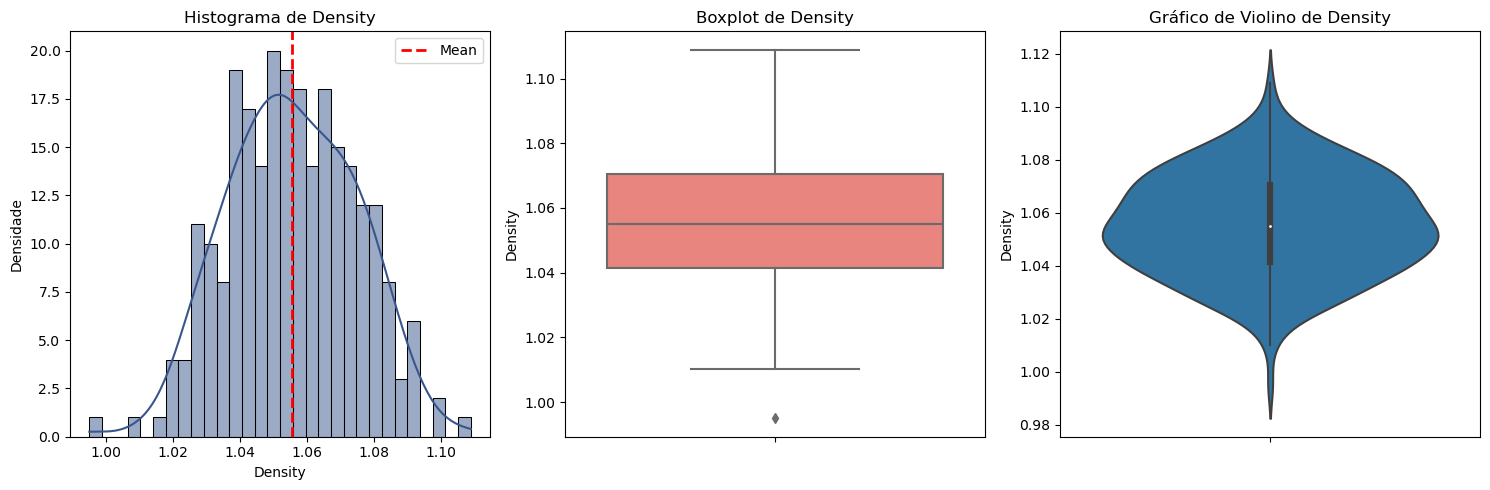

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


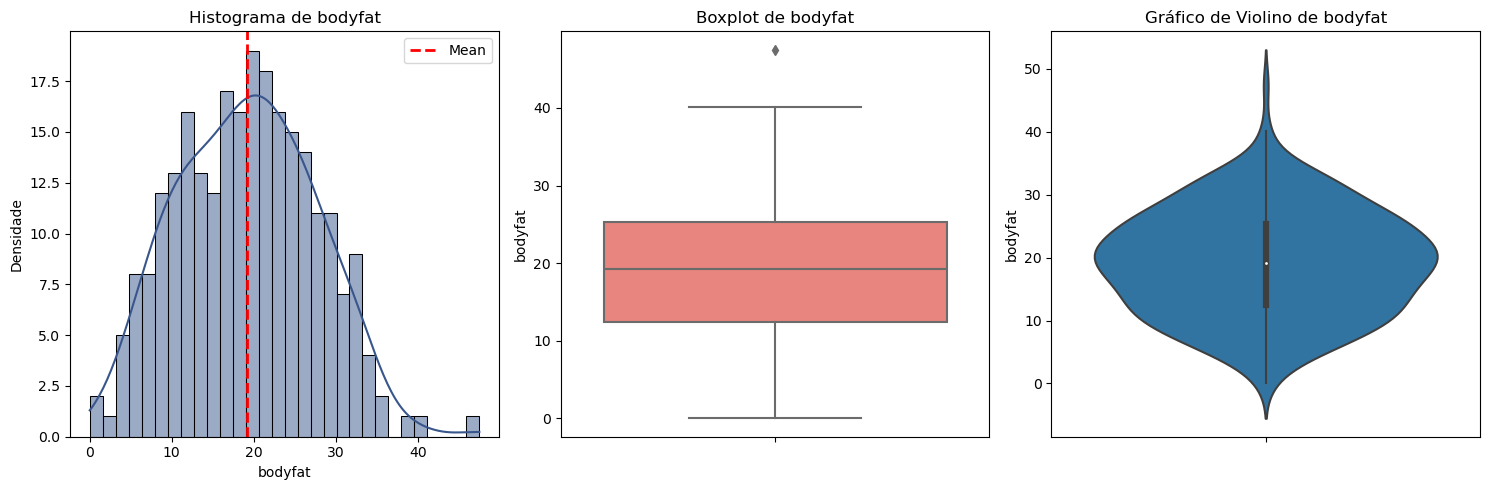

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


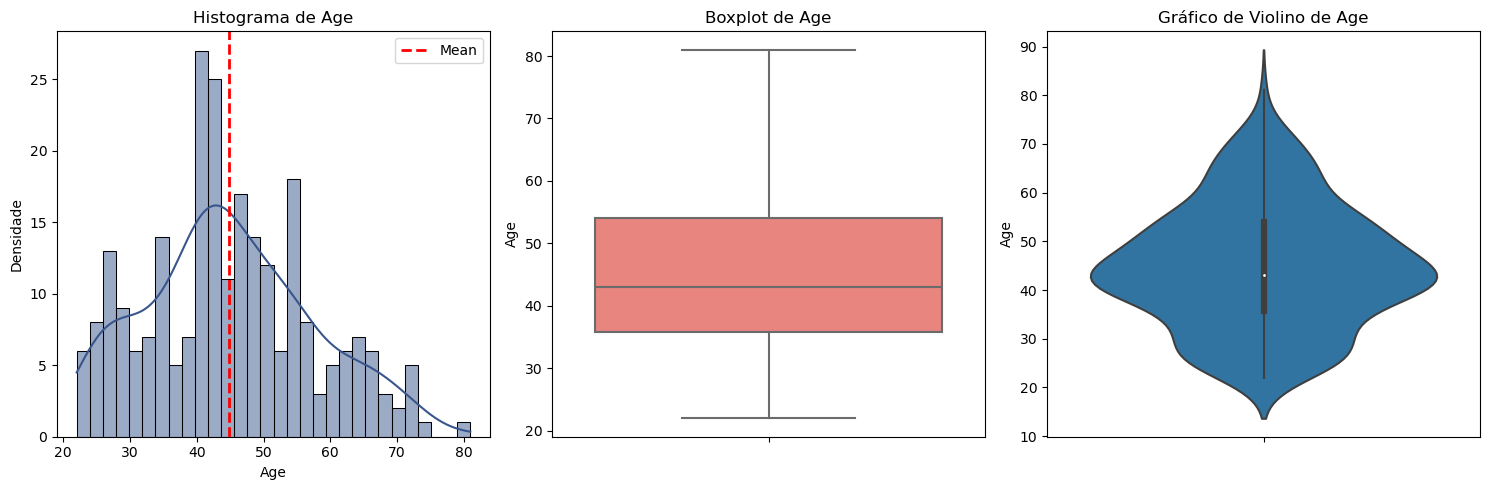

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


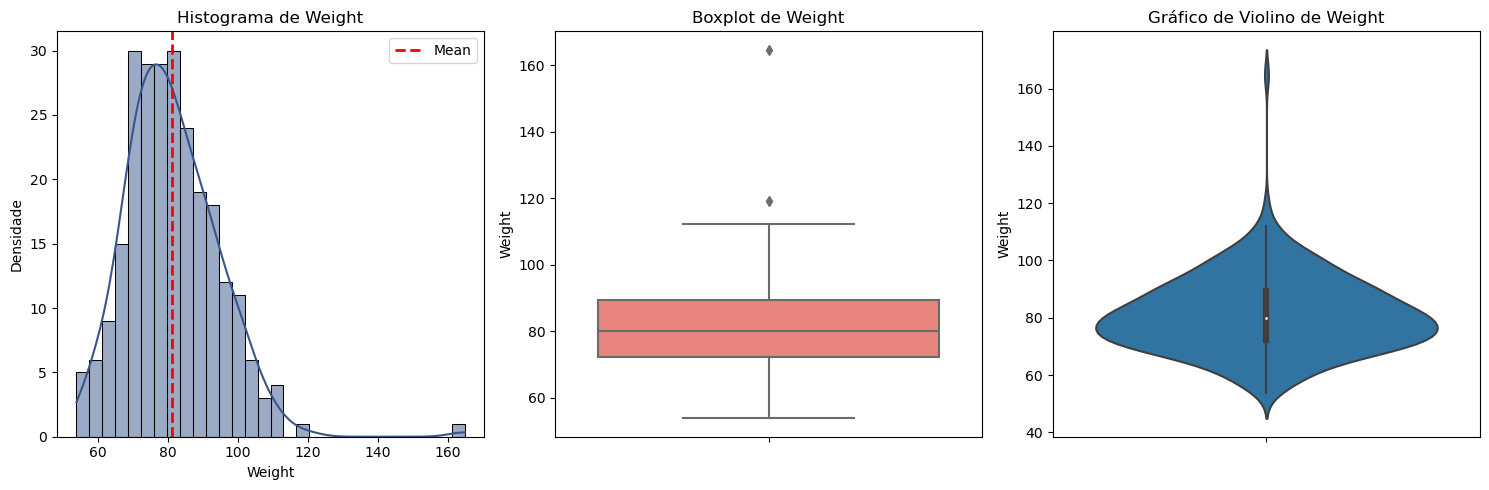

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


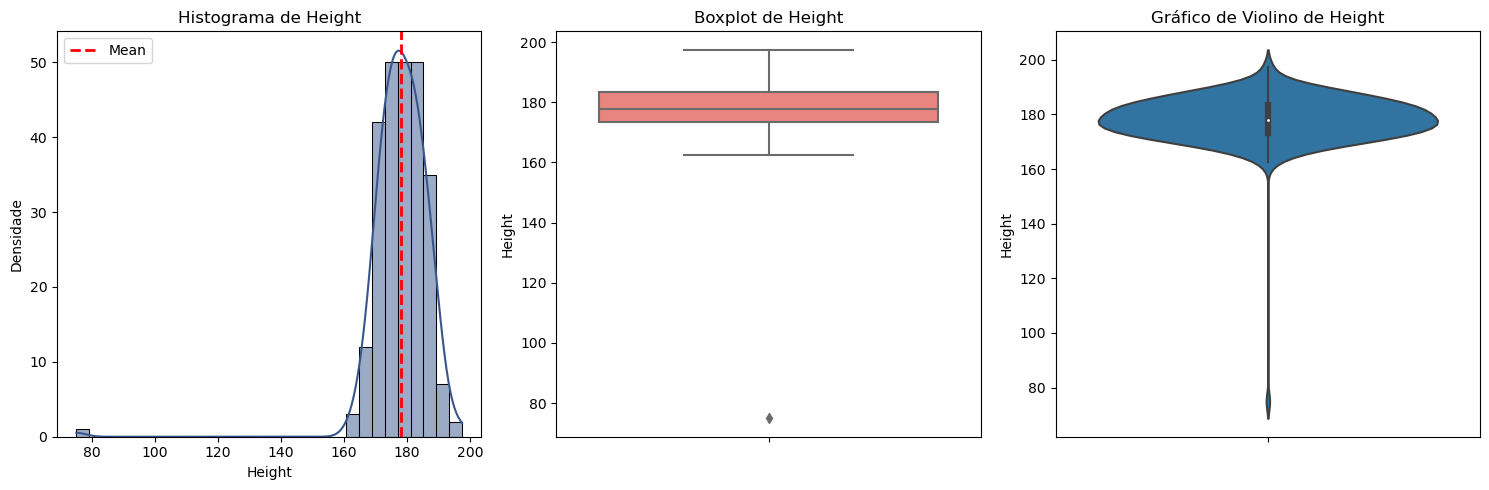

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


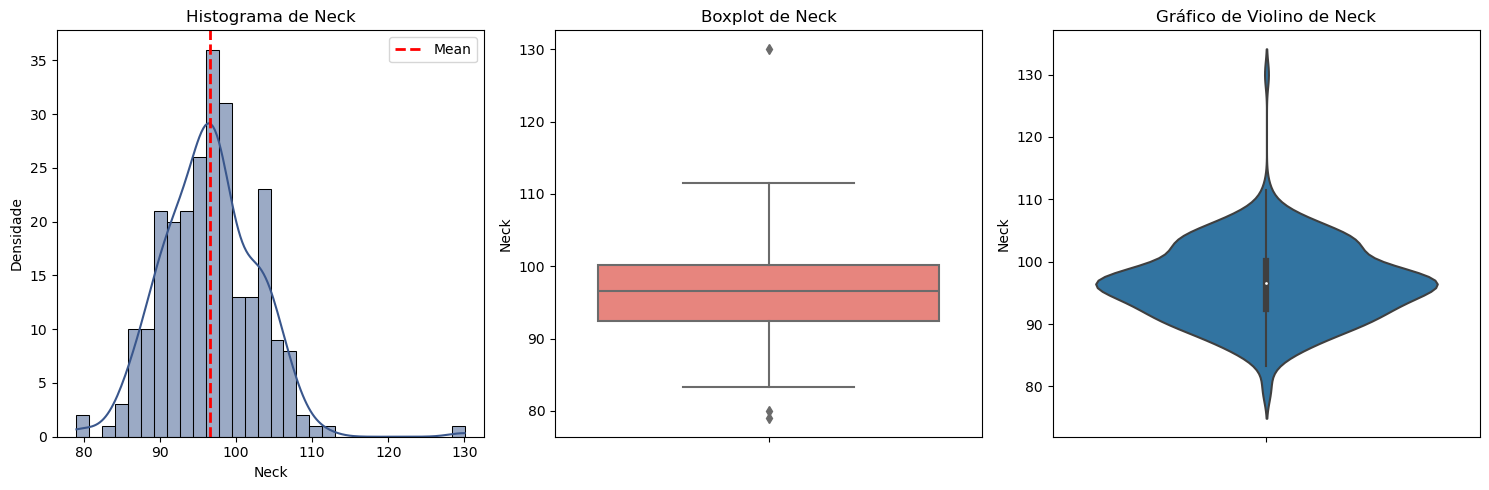

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


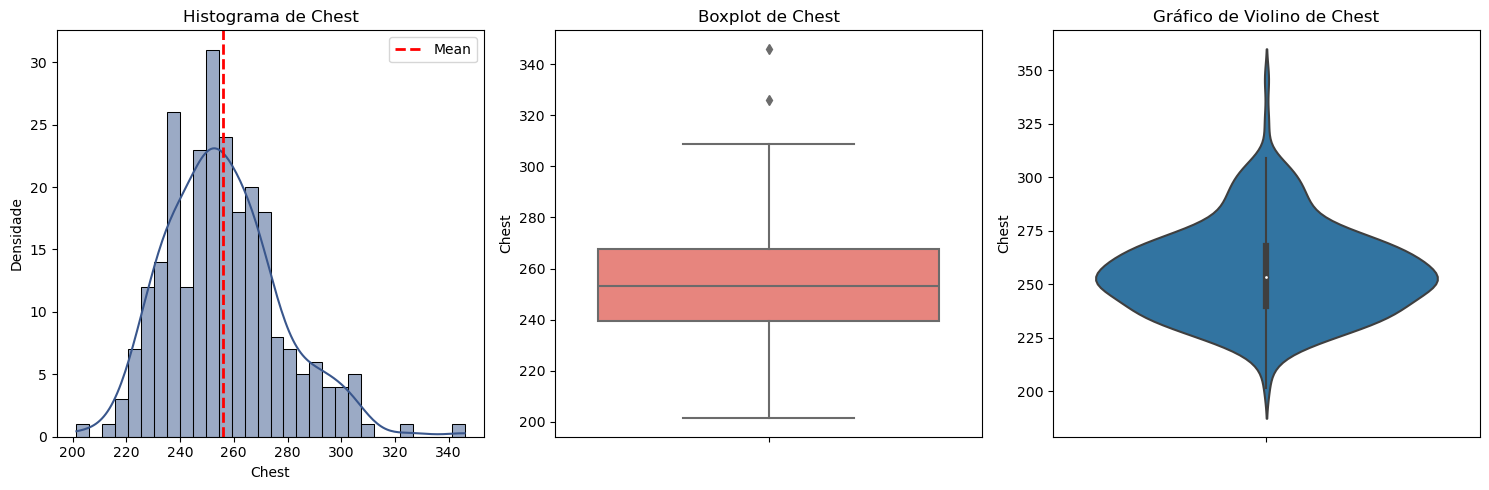

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


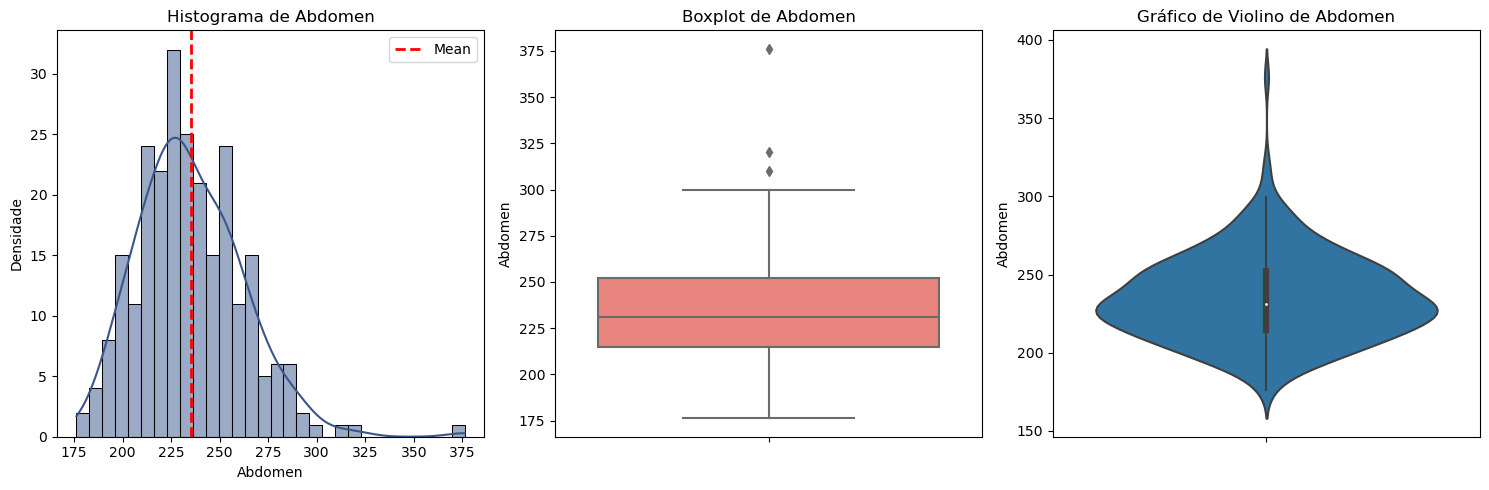

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


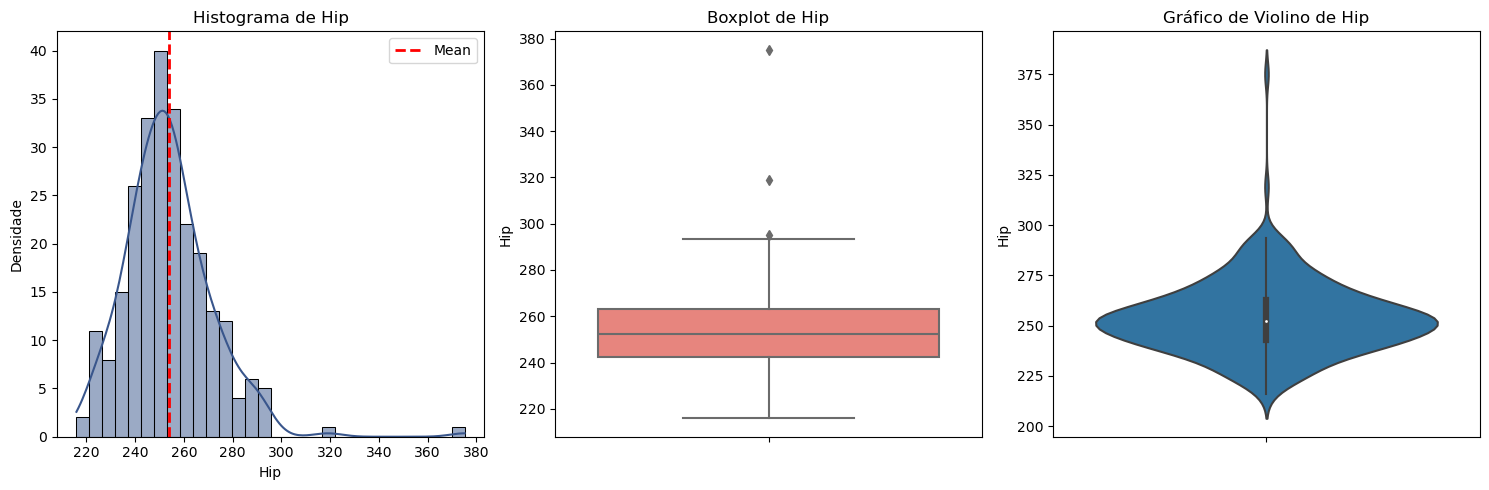

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


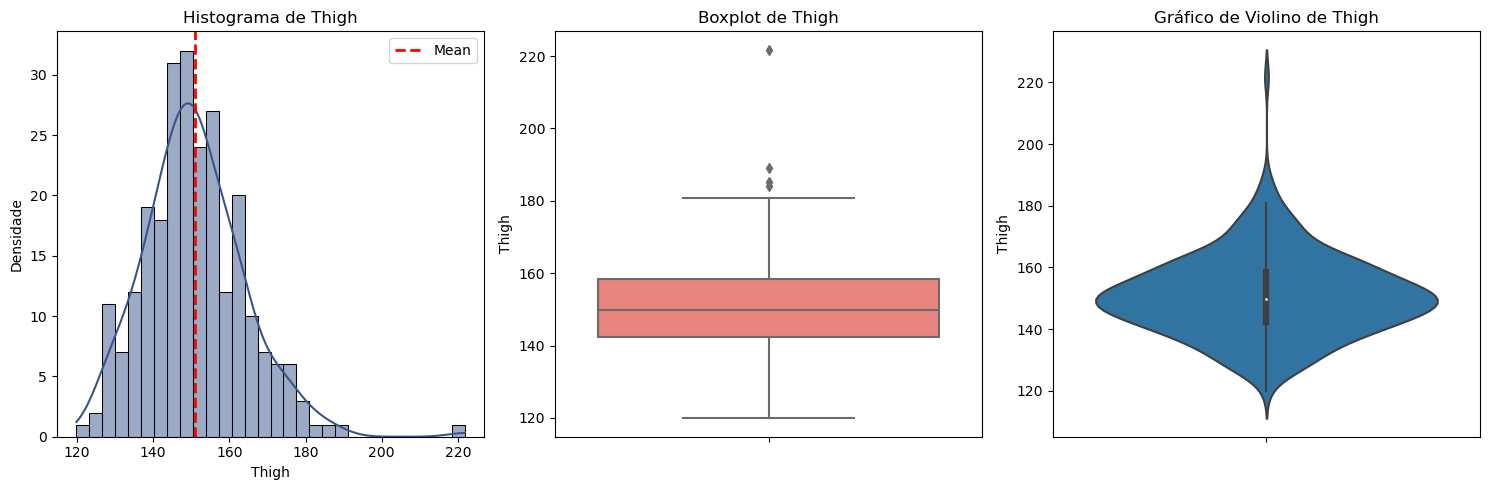

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


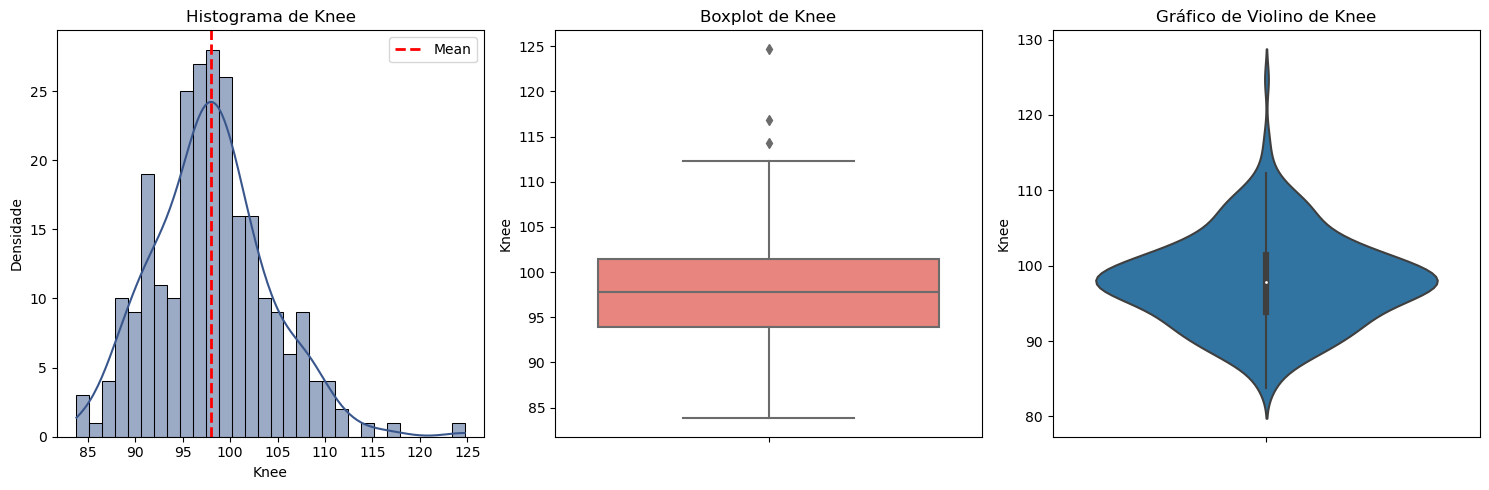

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


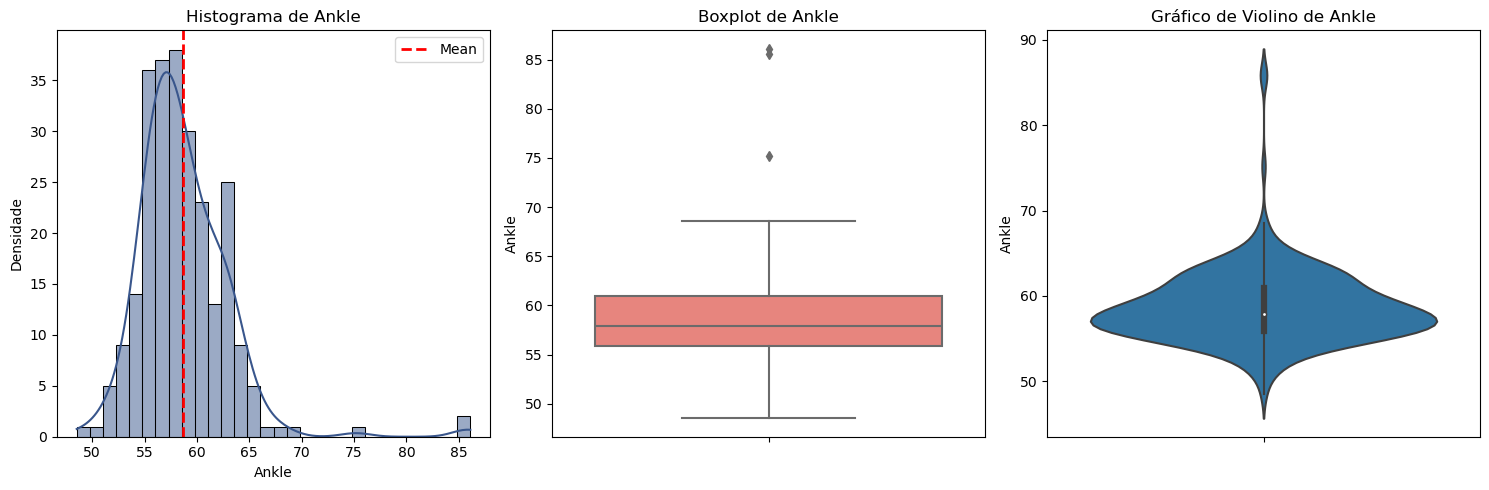

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


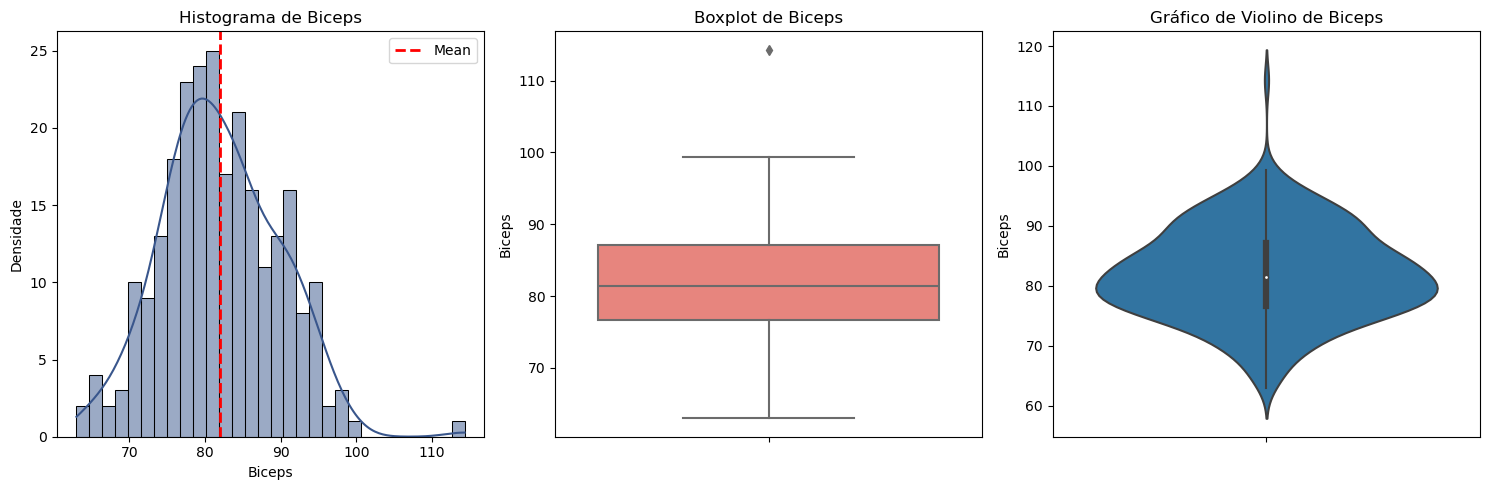

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


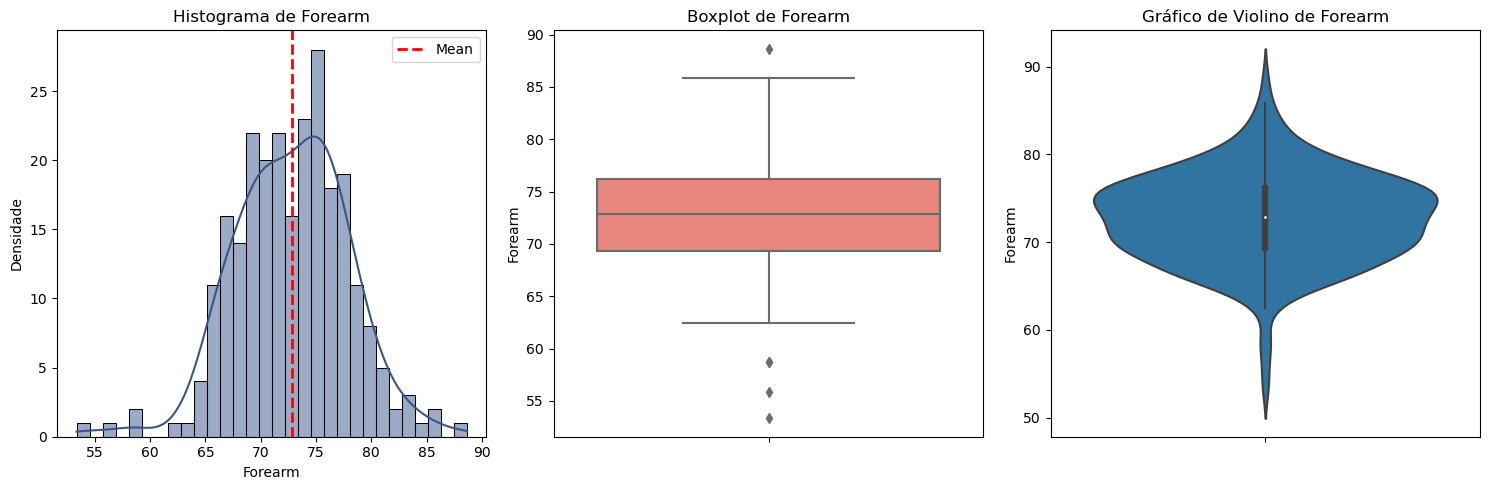

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


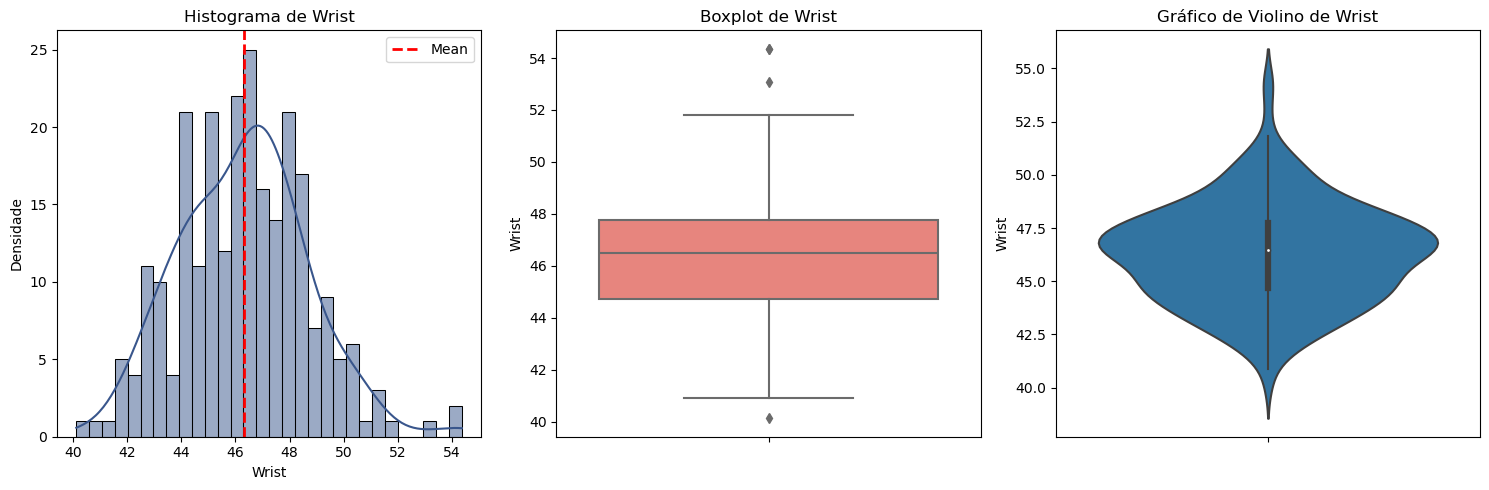

In [199]:
# Gerando boxplot, histograma e violino de cada variável
def plot_histogram_boxplot(df):
    
    # Gera histogramas e boxplots para todas as colunas numéricas de um DataFrame.

    num_cols = df.select_dtypes(include=['number']).columns  # Filtra apenas colunas numéricas
    
    for coluna in num_cols:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Criar subplots lado a lado

        # Histograma com densidade
        sns.histplot(df[coluna], kde=True, bins=30, color="#39568C", ax=axes[0]) # kde=True adiciona a curva de densidade
        axes[0].set_title(f"Histograma de {coluna}")
        axes[0].set_ylabel("Densidade")
        axes[0].axvline(df[coluna].mean(), color='red', linestyle='dashed', linewidth=2, label="Mean")  # Linha da média
        axes[0].legend() 

        # Boxplot
        sns.boxplot(y=df[coluna], color="#F8766D", ax=axes[1])
        axes[1].set_title(f"Boxplot de {coluna}")

        # Gráfico de violino
        sns.violinplot(y=df[coluna], ax=axes[2])
        axes[2].set_title(f"Gráfico de Violino de {coluna}")

        plt.tight_layout()
        plt.show()

# Exemplo de uso:
plot_histogram_boxplot(df)

## <center>3. Preparação dos dados

#### <code style="color:green">Pré-processamento e Limpeza dos dados</code>

- Verificar observações sobre a análise univariada com a área de negócio e realizar tratamento dos dados
- Criar ABT
- Realizar transformação de dados quando necessário

In [200]:
# tirando uma variavel que não será usada (contexto negocio)
df = df.drop(["Density"], axis=1)
df

,bodyfat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,69.966566,172.085,91.948,236.474,216.408,240.030,149.860,94.742,55.626,81.280,69.596,43.434
1,6.1,22,78.584814,183.515,97.790,237.744,210.820,250.698,149.098,94.742,59.436,77.470,73.406,46.228
2,25.3,22,69.853168,168.275,86.360,243.332,223.266,251.968,151.384,98.806,60.960,73.152,64.008,42.164
3,10.4,26,83.801122,183.515,94.996,258.572,219.456,257.048,152.654,94.742,57.912,82.296,74.676,46.228
4,28.7,24,83.574326,180.975,87.376,247.142,254.000,258.826,160.528,107.188,60.960,81.788,70.358,44.958
5,20.9,24,95.367718,189.865,99.060,265.430,239.776,273.812,167.640,106.680,65.024,90.678,77.724,47.752
6,19.2,26,82.100152,177.165,92.456,266.954,230.378,254.762,148.336,97.282,58.166,81.026,70.612,44.958
7,12.4,25,79.832192,184.150,96.012,252.984,224.790,246.634,152.400,100.076,58.928,77.470,73.660,47.752
8,4.1,25,86.636072,187.960,96.774,256.286,209.550,253.746,159.766,97.282,60.452,91.186,78.994,46.228
9,11.7,23,89.924614,186.690,106.934,252.984,225.044,264.414,160.274,105.918,63.500,90.424,76.200,48.768


In [201]:
# Atribuir o valor da média da altura de todas as observações (adultos) ao outlier de Height ( = 74.93)

df['Height'] = df['Height'].replace(74.93, df['Height'].mean())

df.describe().T


,count,mean,std,min,25%,50%,75%,max
bodyfat,252.0,19.150794,8.368740,0.000000,12.475000,19.200000,25.300000,47.500000
Age,252.0,44.884921,12.602040,22.000000,35.750000,43.000000,54.000000,81.000000
Weight,252.0,81.158679,13.330688,53.750652,72.121128,80.058988,89.357624,164.721935
Height,252.0,178.587690,6.627122,162.560000,173.355000,177.988988,183.515000,197.485000
Neck,252.0,96.499841,6.174520,78.994000,92.456000,96.520000,100.139500,130.048000
Chest,252.0,256.093484,21.413408,201.422000,239.649000,253.111000,267.652500,345.948000
Abdomen,252.0,235.092119,27.389015,176.276000,214.820500,231.013000,252.285500,376.174000
Hip,252.0,253.758095,18.196706,215.900000,242.570000,252.222000,262.953500,375.158000
Thigh,252.0,150.891119,13.334878,119.888000,142.240000,149.860000,158.369000,221.742000
Knee,252.0,98.019810,6.125984,83.820000,93.916500,97.790000,101.409500,124.714000


## <center>4. Análise exploratória dos dados

#### <code style="color:green">Etapas da EDA</code>

- Análise bivariada
- Avaliar e tratar multicolinearidade
- Fazer descritiva com foco no modelo
- Validar pressupostos

## <code style="color:green">Análise Bivariada</code>

- Cruzar variáveis e identificar correlação de pearson
- Observar relação entre cada variável independente e a variável dependente para identificar correlação visualmente (vontade de traçar uma reta angular?)
- Analisar matriz de correlação (acima de 0,7 indica alta correlação)
- Escolhar quais variáveis manter no modelo

| **Análise**       | **Função/Ferramenta**                       | **Instrução**                                  | **Exemplos** |
|-------------------|---------------------------------------------|------------------------------------------------|--------------|
| **Colinearidade** | Gráficos de dispersão, matriz de correlação | Identificar relações lineares entre variáveis. | - |


Essa análise ajuda a evitar problemas como multicolinearidade no modelo.

#### <code style="color:purple">Observações - Análise Bivariada</code>


c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\laris\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

<Figure size 1200x1000 with 0 Axes>

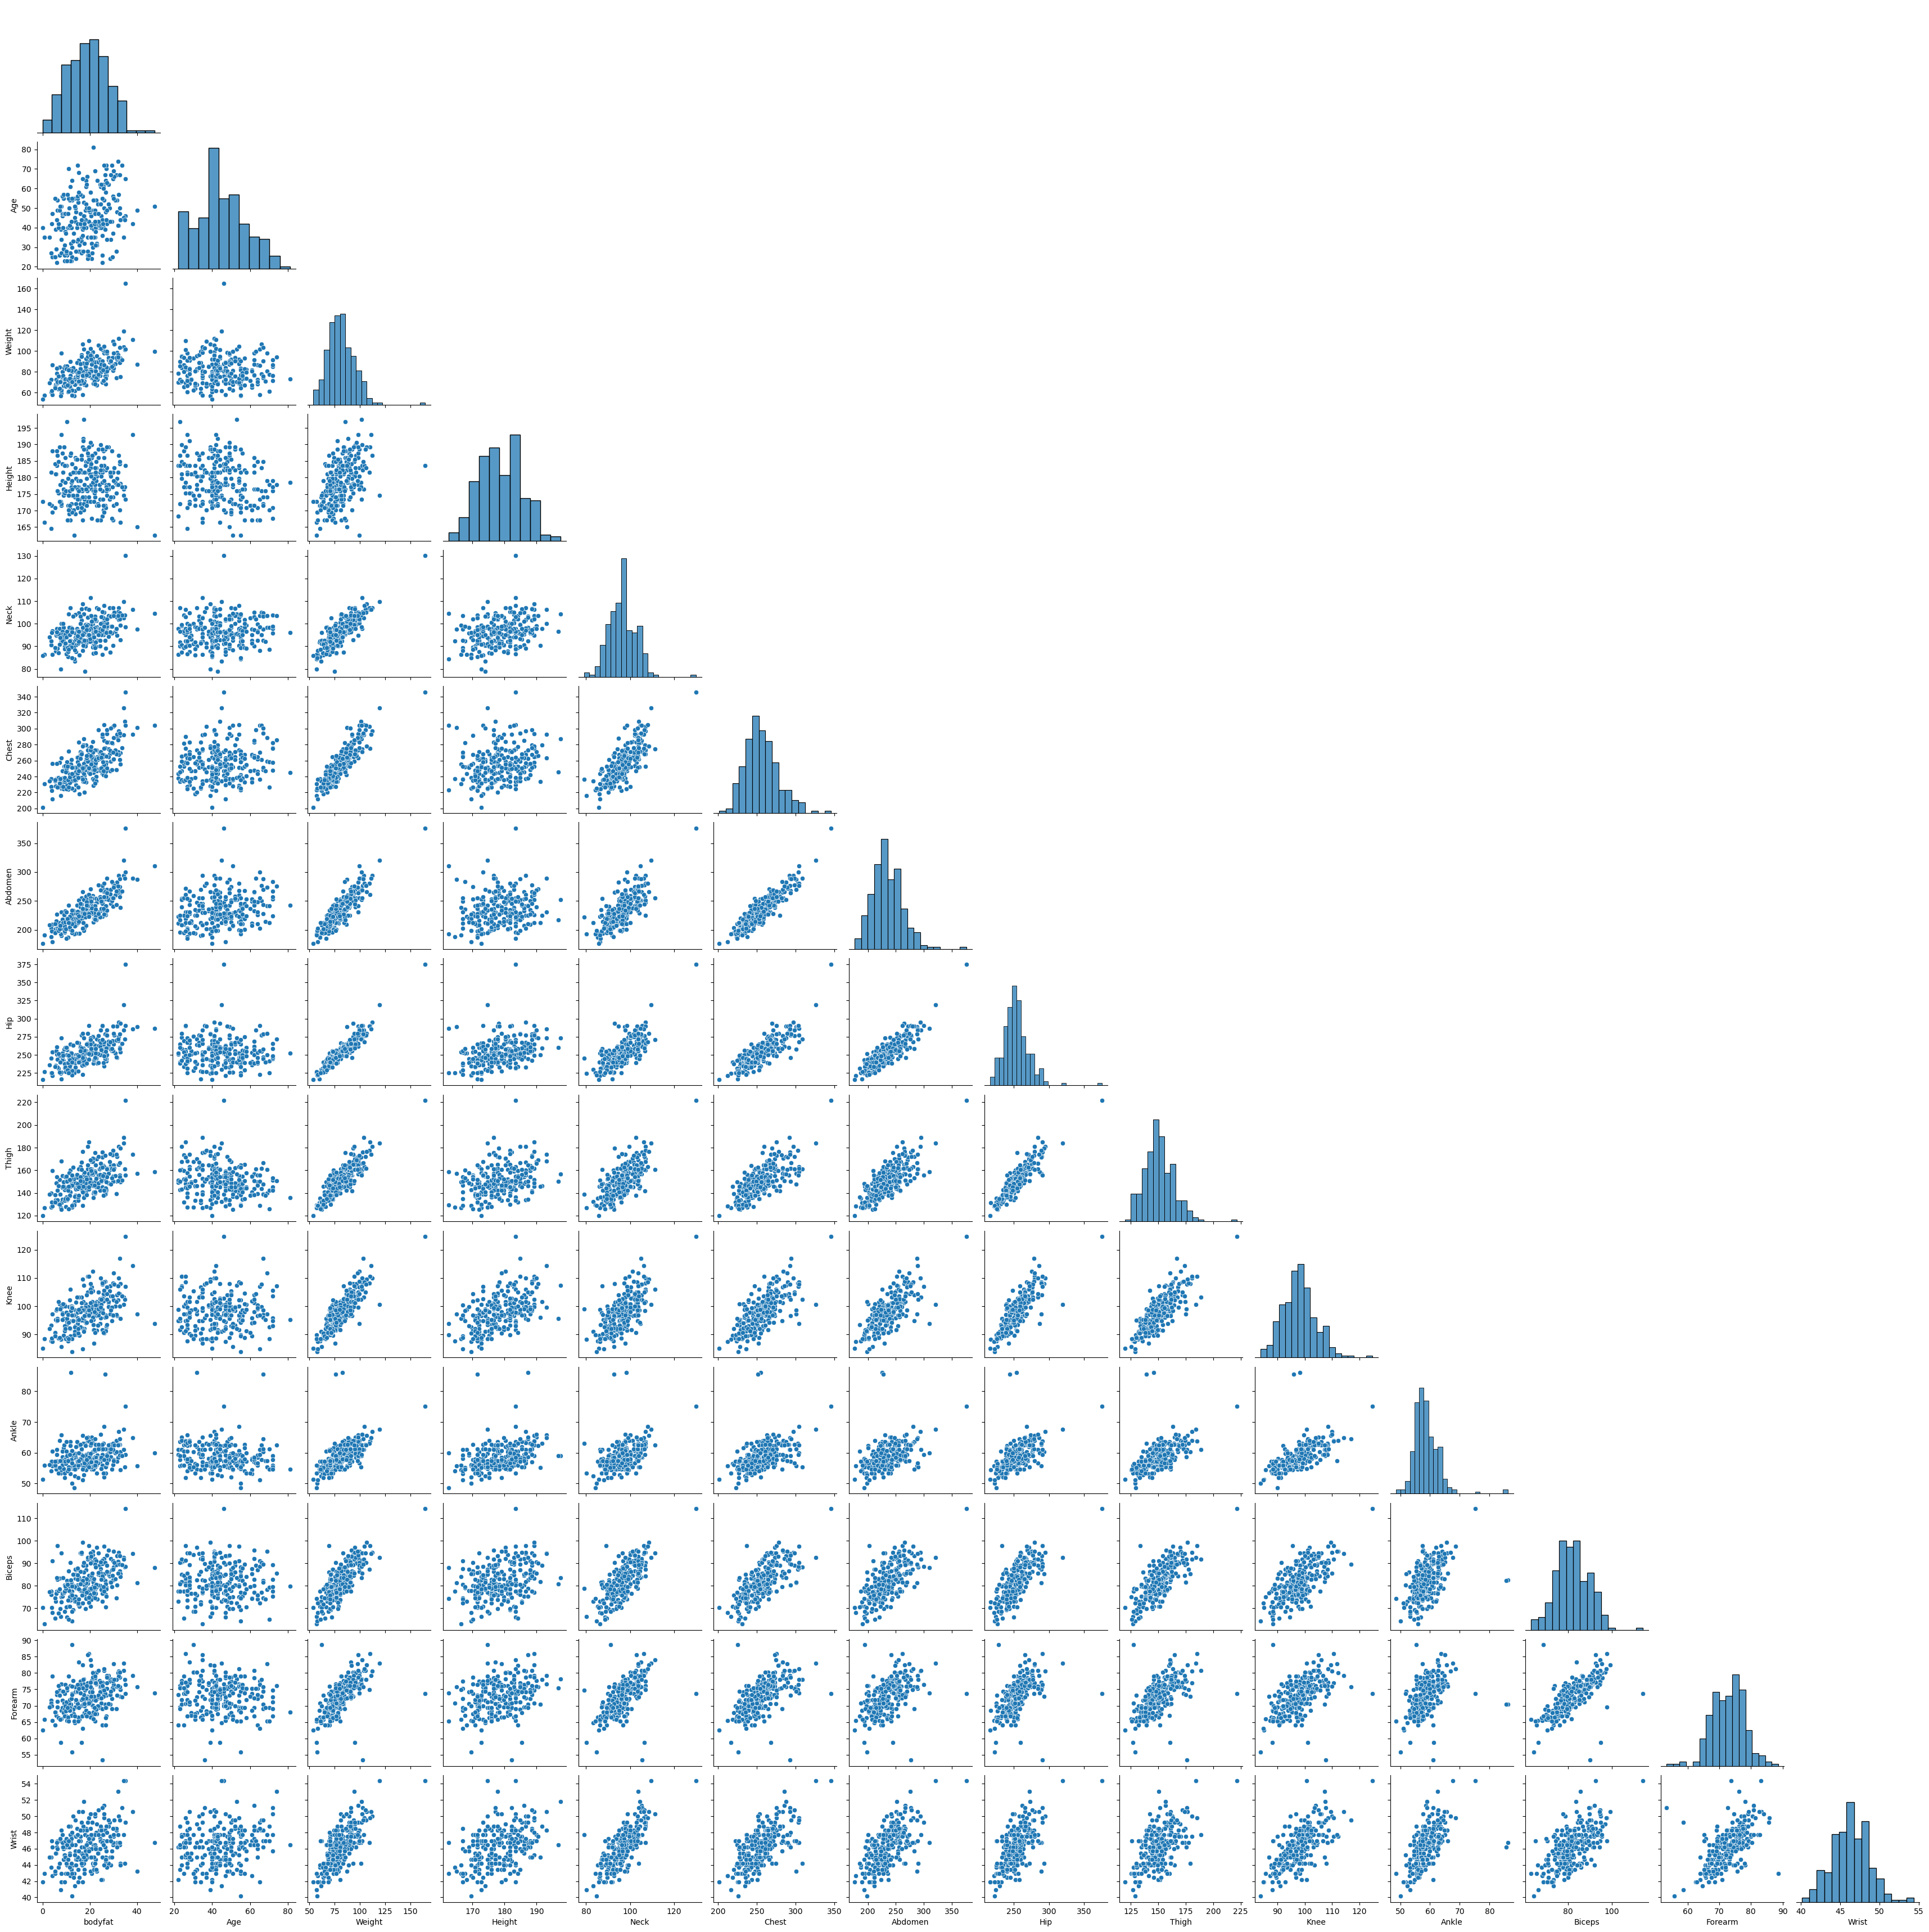

In [202]:
# Gerando gráficos de dispersão entre todas as variáveis

# Ajustar o tamanho da figura
plt.figure(figsize=(12, 10))  # Ajuste o tamanho conforme necessário

# Verificar linearidade (gráficos de dispersão)
sns.pairplot(df, corner=True)

# Mostrar o gráfico
plt.show()

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


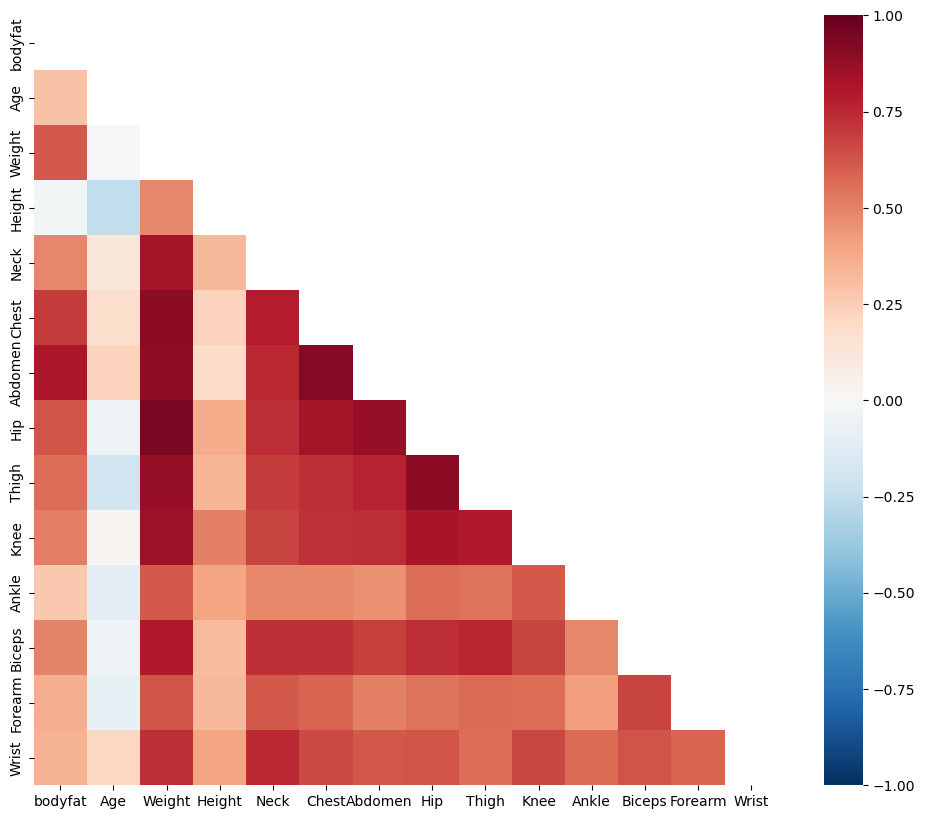

In [203]:
# Heatmap para cálculo de correlação com valores de correlação

# corr_matrix = pd.concat([y, X], axis=1).corr()
corr_matrix = df.corr()

# Criar a máscara para a parte superior da matriz, evitando redundância já que a matriz é simétrica
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

# Ajustar o tamanho da figura
plt.figure(figsize=(12, 10))

# Criar o heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.1f', center=0, vmax=1, vmin=-1, cmap="RdBu_r", annot_kws={"size": 10}, mask=mask)
plt.show()


<code style="color:purple">Observações</code>

- Pode-se observar que as variáveis Ankle, Age e Height, no gráfico de dispersão, não apresentam um comportamente linear. Vamos retirá-las do df para rodar o primeiro modelo.

- Também observa-se que a variável Weight possui correlação forte com Hip, Abdomen, Chest, Thigh e Knee. Isso pode causar multicolinearidade no modelo.

<code style="color:red">Dúvida</code>

   - Ao observar que a variável Weight possui correlação forte com várias outras variáveis, como testar qual podemos retirar para gerar o melhor modelo?

## <center>5. Modelagem

### <center>Criando o modelo de regressão linear múltipla

In [204]:
# Definir a variável dependente (y) e as independentes (X)

# Criando o objeto y com a variável dependente
y = df["bodyfat"]
# Criando a matriz X sem a variável dependente
X = df.drop(columns=["bodyfat"])  # Usando todas as variáveis independentes numéricas

# Adicionando uma coluna com todos os valores = 1 para que o B0 seja calculado
X = sm.add_constant(X)

# Ajustando o modelo
modelo_full = sm.OLS(y, X).fit()
# Resumo do modelo
print(modelo_full.summary())
# Gerando a predição através deste modelo
chute_modelo_full = modelo_full.predict(X)

"""
Existe a opção de utilizar o Scikit-Learn para predições e deploy, mas é menos detalhado para análise estatística. Não precisa adicionar constante. 

Para utilizar este método, separaríamos as observações em test e treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)
"""

                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.50
Date:                sex, 21 mar 2025   Prob (F-statistic):           9.75e-64
Time:                        11:02:48   Log-Likelihood:                -718.50
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.6699     22.158     -0.978      0.3

'\nExiste a opção de utilizar o Scikit-Learn para predições e deploy, mas é menos detalhado para análise estatística. Não precisa adicionar constante. \n\nPara utilizar este método, separaríamos as observações em test e treino\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)\n\nmodelo = LinearRegression()\nmodelo.fit(X_train, y_train)\n'

<code style="color:purple">Resultados do modelo com todas as variáveis independentes</code>

De acordo com os resultados obtidos na regressão utilizando todas as variáveis independentes, observa-se que:

- **P>|t|**  A maior parte das variáveis independentes deste modelo são não significativas.
- **Test F (Prob (F-statistic))**:	9.75e-64, indica que pelo menos 1 variável independente é significativa.
- **Cond. No.** = 4.37e+04 nos dá um indício do motivo deste resultado, já que por ser muito grande, indica alta multicolinearidade entre as variáveis.
- **R2** = 0.749: O modelo explica 74.9% da variação do percentual de gordura corporal (bodyfat), o que indica um bom ajuste.
- **𝑅2 ajustado** = 0.735 → Leva em conta o número de variáveis no modelo e é um pouco menor, sugerindo que algumas variáveis podem não estar contribuindo significativamente.
**Estatística F** = 54.50 → Testa se pelo menos uma variável independente tem um coeficiente diferente de zero.
**p-valor do F-statistic**: 9.75e-64 → Extremamente pequeno, indicando que o modelo é estatisticamente significativo.

<code style="color:purple">Comentários</code>

Antes de utilizar um método de seleção de variáveis, vamos retirar algumas variáveis do df que foram identificadas com baixa correlação com a variável dependente. 

In [205]:
# Criando uma nova matriz X sem as variáveis Height, Age e Ankle
X_manual = df.drop(columns=["bodyfat", "Height", "Age", "Ankle"])  # Usando todas as variáveis independentes numéricas, exceto Height, Age e Ankle

# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X_manual = sm.add_constant(X_manual)
# Ajustando o modelo
manual = sm.OLS(y, X_manual).fit()
# Resumo do modelo
print(manual.summary()) 
# gerando a predição aravés desse modelo
pred_manual = manual.predict(X_manual)


                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     69.93
Date:                sex, 21 mar 2025   Prob (F-statistic):           1.67e-65
Time:                        11:02:48   Log-Likelihood:                -720.91
No. Observations:                 252   AIC:                             1464.
Df Residuals:                     241   BIC:                             1503.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -28.0892     13.680     -2.053      0.0

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


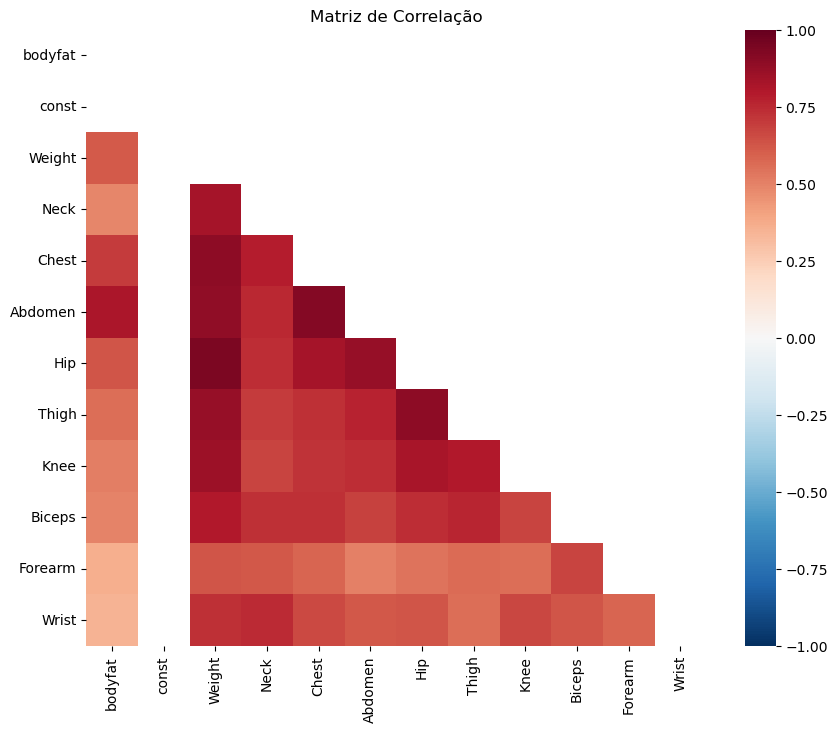

In [206]:
# Heatmap para cálculo de correlação com valores de correlação

# vamos pegar da primeira até  a 14 coluna
corr_matrix = pd.concat([y,X_manual], axis=1).corr(method='pearson')

# Criar a máscara para a parte superior da matriz, evitando redundância já que a matriz é simétrica
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

# Visualiza a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', center=0, vmax=1, vmin=-1, cmap="RdBu_r", annot_kws={"size": 10}, mask=mask)
plt.title('Matriz de Correlação')
plt.show()

### <code style="color:green">Seleção de Variáveis</code>

Seleção de variáveis é uma etapa que objetiva selecionar apenas as variáveis úteis para o modelo.

#### <center>Métodos:

| **Método**                  | **Melhor para**      | **Vantagens**    | **Desvantagens**      | **Popularidade** |
|-----------------------------|----------------------|------------------|-----------------------|------------------|
| **Lasso (Regularização L1)** | Modelos lineares, muitas variáveis | Fácil de interpretar, evita overfitting           | Pode descartar variáveis importantes           | 4              |
| **Random Forest/XGBoost**   | Qualquer modelo                | Considera interações e relações não lineares       | Difícil de interpretar                         | 5              |
| **RFE (Seleção Recursiva)** | Modelos específicos (Linear, SVM) | Boa seleção para modelos pequenos                  | Computacionalmente caro                        | 3              |
| **Stepwise Selection**      | Modelos estatísticos           | Interpretável                                      | Propenso a overfitting, lento                  | 2              |
| **Mutual Information**      | Dados categóricos              | Lida bem com não-linearidade                      | Difícil de interpretar                         | 2              |

#### <center>Forward AIC

In [229]:
# Realizando a seleção de variáveis pelo método forward com base no AIC, utilizando as funções criadas no início do documento


# Criando o objeto X com as variáveis independentes, ou seja, tirando o que foi feito antes e a variável resposta

X = df.drop(["bodyfat"],axis = 1)

# Criando o objeto y com a variável dependente
y = df["bodyfat"]

colunas_forw = step(var_dependente = 'bodyfat', var_independente = X.columns.to_list(), 
                    base = df, metodo = 'forward', metrica = 'aic')
colunas_forw

,var,aic
8,"[chute_media, Abdomen, Weight, Wrist, Forearm, Neck, Age, Thigh, Hip]",1456.996382
7,"[Hip, Abdomen, Weight, Wrist, Forearm, Neck, Age, Thigh]",1456.996382
6,"[Thigh, Abdomen, Weight, Wrist, Forearm, Neck, Age]",1457.053833
5,"[Age, Abdomen, Weight, Wrist, Forearm, Neck]",1458.806253
4,"[Neck, Abdomen, Weight, Wrist, Forearm]",1459.441862
3,"[Forearm, Abdomen, Weight, Wrist]",1460.219691
2,"[Wrist, Abdomen, Weight]",1465.041213
1,"[Weight, Abdomen]",1471.184778
0,[Abdomen],1515.790337


#### <code style="color:purple">Observações: </code>

- Note que as melhores variáveis estão na primeira linha.
- Tanto no AIC quanto no BIC, quanto menor for o valor, melhor o modelo será
- Agora vamos pegar essas colunas e criar o modelo

In [208]:
# colocando em uma lista o nome de todas as variaveis do modelo com menor aic
X_forw = df[colunas_forw['var'].to_list()[0]]
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X_forw = sm.add_constant(X_forw)
# Ajustando o modelo
forw = sm.OLS(y, X_forw).fit()
# Resumo do modelo
print(forw.summary()) 
# gerando a predição aravés desse modelo
pred_forw = forw.predict(X_forw)

                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     89.47
Date:                sex, 21 mar 2025   Prob (F-statistic):           4.92e-68
Time:                        11:02:49   Log-Likelihood:                -719.50
No. Observations:                 252   AIC:                             1457.
Df Residuals:                     243   BIC:                             1489.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.6564     11.714     -1.934      0.0

#### <code style="color:purple">Observações: </code>

Por que alguns p-valores são não significativos?

#### <center>Backward AIC

In [209]:
# regressao por backward com a regra de AIC
colunas_backw = step(var_dependente = 'bodyfat', var_independente = X.columns.to_list(), base = df, metodo = 'backward' ,metrica = 'aic')
colunas_backw

,var,aic
5,"[Age, Weight, Neck, Abdomen, Hip, Thigh, Forearm, Wrist]",1456.996382
4,"[Age, Weight, Neck, Abdomen, Hip, Thigh, Biceps, Forearm, Wrist]",1457.822171
3,"[Age, Weight, Neck, Abdomen, Hip, Thigh, Ankle, Biceps, Forearm, Wrist]",1459.066261
2,"[Age, Weight, Height, Neck, Abdomen, Hip, Thigh, Ankle, Biceps, Forearm, Wrist]",1461.033569
1,"[Age, Weight, Height, Neck, Chest, Abdomen, Hip, Thigh, Ankle, Biceps, Forearm, Wrist]",1463.005994
0,"[Age, Weight, Height, Neck, Chest, Abdomen, Hip, Thigh, Knee, Ankle, Biceps, Forearm, Wrist]",1465.003082


In [210]:
# colocando em uma lista o nome de todas as variaveis do modelo com menor aic
X_backw = df[colunas_backw['var'].to_list()[0]] 
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X_backw = sm.add_constant(X_backw)
# Ajustando o modelo
backw = sm.OLS(y, X_backw).fit()
# Resumo do modelo
print(backw.summary()) 
# gerando a predição aravés desse modelo
pred_backw = backw.predict(X_backw)

                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     89.47
Date:                sex, 21 mar 2025   Prob (F-statistic):           4.92e-68
Time:                        11:02:49   Log-Likelihood:                -719.50
No. Observations:                 252   AIC:                             1457.
Df Residuals:                     243   BIC:                             1489.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.6564     11.714     -1.934      0.0

#### <center>Stepwise AIC

In [211]:
# regressao por stepwise com a regra de AIC
colunas_stepw = step(var_dependente = 'bodyfat', var_independente = X.columns.to_list(), base = df, metodo = 'both' ,metrica = 'aic')
colunas_stepw

,var,aic
0,"[Hip, Abdomen, Weight, Wrist, Forearm, Neck, Age, Thigh]",1456.996382


In [212]:
# colocando em uma lista o nome de todas as variaveis do modelo com menor aic
X_stepw = df [ colunas_stepw['var'].to_list()[0] ] 
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X_stepw = sm.add_constant(X_stepw)
# Ajustando o modelo
stepw = sm.OLS(y, X_stepw).fit()
# Resumo do modelo
print(stepw.summary()) 
# gerando a predição aravés desse modelo
pred_stepw = stepw.predict(X_stepw)

                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     89.47
Date:                sex, 21 mar 2025   Prob (F-statistic):           4.92e-68
Time:                        11:02:50   Log-Likelihood:                -719.50
No. Observations:                 252   AIC:                             1457.
Df Residuals:                     243   BIC:                             1489.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.6564     11.714     -1.934      0.0

In [213]:
X

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,23,69.966566,172.085000,91.948,236.474,216.408,240.030,149.860,94.742,55.626,81.280,69.596,43.434
1,22,78.584814,183.515000,97.790,237.744,210.820,250.698,149.098,94.742,59.436,77.470,73.406,46.228
2,22,69.853168,168.275000,86.360,243.332,223.266,251.968,151.384,98.806,60.960,73.152,64.008,42.164
3,26,83.801122,183.515000,94.996,258.572,219.456,257.048,152.654,94.742,57.912,82.296,74.676,46.228
4,24,83.574326,180.975000,87.376,247.142,254.000,258.826,160.528,107.188,60.960,81.788,70.358,44.958
5,24,95.367718,189.865000,99.060,265.430,239.776,273.812,167.640,106.680,65.024,90.678,77.724,47.752
6,26,82.100152,177.165000,92.456,266.954,230.378,254.762,148.336,97.282,58.166,81.026,70.612,44.958
7,25,79.832192,184.150000,96.012,252.984,224.790,246.634,152.400,100.076,58.928,77.470,73.660,47.752
8,25,86.636072,187.960000,96.774,256.286,209.550,253.746,159.766,97.282,60.452,91.186,78.994,46.228
9,23,89.924614,186.690000,106.934,252.984,225.044,264.414,160.274,105.918,63.500,90.424,76.200,48.768


In [214]:
# regressao por stepwise com a regra de p-valor


colunas_stepw_p = step(var_dependente = 'bodyfat', var_independente = X.columns.to_list(), base = df, metodo = 'both' ,metrica = 'pvalor')
colunas_stepw_p


C:\Users\laris\AppData\Local\Temp\ipykernel_6508\3468212101.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalor = modelo.pvalues[1]
C:\Users\laris\AppData\Local\Temp\ipykernel_6508\3468212101.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalor = modelo.pvalues[1]
C:\Users\laris\AppData\Local\Temp\ipykernel_6508\3468212101.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalor = modelo.pvalues[1]
C:\Users\laris\A

,var
0,Abdomen
1,Weight
2,Wrist
3,Forearm


In [215]:
# colocando em uma lista o nome de todas as variaveis do modelo com p-valor
X_stepw_p = df[colunas_stepw_p['var'].to_list()] 
# Aqui lembre-se do B0. Basicamente vamos adicionar uma coluna de 1s para que o B0 seja calculado.
X_stepw_p = sm.add_constant(X_stepw_p)
# Ajustando o modelo
stepw_p = sm.OLS(y, X_stepw_p).fit()
# Resumo do modelo
print(stepw_p.summary()) 
# gerando a predição aravés desse modelo
pred_stepw_p = stepw_p.predict(X_stepw_p)

                            OLS Regression Results                            
Dep. Variable:                bodyfat   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     171.3
Date:                sex, 21 mar 2025   Prob (F-statistic):           5.39e-70
Time:                        11:02:51   Log-Likelihood:                -725.11
No. Observations:                 252   AIC:                             1460.
Df Residuals:                     247   BIC:                             1478.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.8541      7.245     -4.811      0.0

### <center>Verificando a qualidade dos modelos

### <code style="color:green">Interpretando os Resultados - Métricas de Qualidade de Ajuste</code>

| **Métrica**                      | **Descrição**                                                                                                                                                         | **Interpretação**                                                                 |
|----------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| **Dep. Variable**                | Variável dependente do modelo.                                                                                                                                    | Define a variável que estamos tentando prever.                                  |
| **Model**                        | Modelo de regressão utilizado.                                                                                                                                   | Indica se foi uma regressão OLS ou outro tipo de modelo.                        |
| **Method**                       | Método utilizado para estimar os parâmetros.                                                                                                                      | Normalmente, OLS (Ordinary Least Squares).                                      |
| **Date e Time**                  | Data e horário da análise.                                                                                                                                        | Apenas informativo, não influencia a interpretação.                             |
| **No. Observations**             | Número de observações usadas na regressão.                                                                                                                        | Indica o tamanho da amostra.                                                    |
| **Df Residuals**                 | Graus de liberdade dos resíduos (número de observações - número de variáveis).                                                                                   | Usado para interpretar a significância estatística.                             |
| **Df Model**                     | Número de variáveis independentes no modelo.                                                                                                                      | Indica a complexidade do modelo.                                                |
| **$R^{2}$**                      | Mede a proporção da variação de y explicada pelo modelo em %. Quanto mais próximo de 1 (100%), melhor o ajuste.                                                  | Se baixo, modelo não explica bem a variabilidade de y. Se muito alto, pode indicar overfitting. |
| **$R^{2}$ ajustado**             | Penaliza modelos com muitas variáveis irrelevantes.                                                                                                              | Se muito menor que $R^{2}$, algumas variáveis podem não contribuir significativamente. Útil para comparar modelos com diferentes números de variáveis. |
| **Estatística F**                | Testa a significância global do modelo.                                                                                                                           | Se significativa (F alto comparando com F tabelado), modelo tem pelo menos uma variável relevante (coeficiente diferente de zero). |
| **Prob (F-statistic)**           | Probabilidade associada à estatística F. Se < 0,05, rejeita-se H0, indicando que pelo menos uma variável independente é significativa.                            | Se < 0,05, modelo é estatisticamente significativo. |
| **Log-Likelihood**               | Mede a qualidade do ajuste (log-verossimilhança).                                                                                                                | Comparável entre modelos; quanto maior, melhor. |
| **AIC e BIC**                    | Critérios para comparar modelos. BIC penaliza mais modelos com muitas variáveis.                                                                                 | Valores menores indicam melhor ajuste com menos complexidade. |
| **Omnibus**                      | Teste estatístico para verificar se os resíduos seguem uma distribuição normal.                                                                                   | Se p-valor for alto, não rejeitamos a hipótese de normalidade. |
| **Prob(Omnibus)**                | Probabilidade associada ao teste Omnibus.                                                                                                                         | Se < 0,05, os resíduos não seguem distribuição normal. |
| **Skew**                         | Mede a assimetria da distribuição dos resíduos.                                                                                                                   | Valores próximos de 0 indicam simetria; valores muito negativos ou positivos indicam assimetria. |
| **Kurtosis**                     | Mede a curtose da distribuição dos resíduos.                                                                                                                      | Valores próximos de 3 indicam distribuição normal. |
| **Durbin-Watson**                | Testa a presença de autocorrelação nos resíduos.                                                                                                                 | Valores próximos de 2 indicam ausência de correlação serial. |
| **Jarque-Bera (JB)**             | Teste de normalidade dos resíduos.                                                                                                                                | Se p-valor < 0,05, rejeita-se normalidade. |
| **Prob(JB)**                     | Probabilidade associada ao teste JB.                                                                                                                              | Se < 0,05, os resíduos não seguem distribuição normal. |
| **Condition Number**             | Se muito grande, indica multicolinearidade.                                                                                                                       | Valores acima de 30 podem indicar multicolinearidade séria. |
| **Coeficientes (coef)**          | Impacto de cada variável independente sobre y.                                                                                                                    | Valores positivos indicam relação direta; negativos, inversa. Se coeficiente for pequeno e p-valor alto, a variável pode não ser relevante. |
| **Erro padrão (std err)**         | Mede a incerteza na estimativa do coeficiente. Erros menores indicam maior precisão (em diferentes amostras os resultados seriam os mesmos).                     | Se muito alto, pode indicar problema de multicolinearidade ou baixa qualidade da amostra. |
| **Valor t (t)**                  | Estatística de teste para significância dos coeficientes.                                                                                                         | Quanto maior o valor absoluto, mais significativo o coeficiente. |
| **P>[t]**                        | Resultado do teste t para cada variável. Se > 0,05, não rejeitamos H0 (B=0), indicando que a variável pode não ser significativa.                                | Se < 0,05, variável é significativa para prever y. |
| **Intervalo de confiança**       | Faixa onde o coeficiente pode variar com 95% de confiança. Se incluir 0, a variável pode não ser significativa.                                                  | Se intervalo for muito amplo, há grande incerteza na estimativa do coeficiente. |
| **RMSE (Root Mean Squared Error)** | Mede o erro médio quadrático das previsões. Equipara ao desvio padrão. Penaliza erros grandes.                                                                  | Valores mais próximos de 0 indicam melhor ajuste. |
| **MAE (Mean Absolute Error)**     | Mede o erro médio absoluto das previsões. Menos sensível a outliers que RMSE.                                                                                    | Quanto menor, melhor o ajuste do modelo. |
| **Comparação MAE vs RMSE**       | Se RMSE for muito maior que MAE, indica presença de outliers influentes.                                                                                        | Se valores forem próximos, erros estão distribuídos de maneira uniforme. |


| **Métrica**                     | **Modelo_1** | **Modelo_2** | **Modelo_3** | **Modelo_4** | **Modelo_5** |
|----------------------------------|-------------|-------------|-------------|-------------|-------------|
| $R^{2}$                          |             |             |             |             |             |
| $R^{2}$ ajustado                 |             |             |             |             |             |
| Estatística F                    |             |             |             |             |             |
| Prob (F-statistic)                |             |             |             |             |             |
| Log-Likelihood                    |             |             |             |             |             |
| AIC                                |             |             |             |             |             |
| BIC                                |             |             |             |             |             |
| Durbin-Watson                      |             |             |             |             |             |
| Condition Number                   |             |             |             |             |             |
| RMSE                               |             |             |             |             |             |
| MAE                                |             |             |             |             |             |

In [230]:
# Criar um DataFrame para armazenar os resultados de cada modelo (AIC, BIC, RMSE, MAE e R²)

resultados = pd.DataFrame({
    'Modelo': ['Modelo Completo', 'Modelo Manual', 'Forward Stepwise', 'Backward Stepwise', 'Stepwise AIC', 'Stepwise P-Valor'],
    'AIC': [modelo_full.aic, manual.aic, forw.aic, backw.aic, stepw.aic, stepw_p.aic],
    'BIC': [modelo_full.bic, manual.bic, forw.bic, backw.bic, stepw.bic, stepw_p.bic],
    'RMSE': [np.sqrt(mean_squared_error(y, chute_modelo_full)), 
             np.sqrt(mean_squared_error(y, pred_manual)), 
             np.sqrt(mean_squared_error(y, pred_forw)), 
             np.sqrt(mean_squared_error(y, pred_backw)), 
             np.sqrt(mean_squared_error(y, pred_stepw)), 
             np.sqrt(mean_squared_error(y, pred_stepw_p))],
    'R²': [r2_score(y, chute_modelo_full), 
           r2_score(y, pred_manual), 
           r2_score(y, pred_forw), 
           r2_score(y, pred_backw), 
           r2_score(y, pred_stepw), 
           r2_score(y, pred_stepw_p)],
    'MAE': [mean_absolute_error(y, chute_modelo_full), 
            mean_absolute_error(y, pred_manual), 
            mean_absolute_error(y, pred_forw), 
            mean_absolute_error(y, pred_backw), 
            mean_absolute_error(y, pred_stepw), 
            mean_absolute_error(y, pred_stepw_p)]
})

df_resultados = pd.DataFrame(resultados)
# Exibir os resultados formatados como tabela
df_resultados

,Modelo,AIC,BIC,RMSE,R²,MAE
0,Modelo Completo,1465.003082,1514.415089,4.188146,0.748551,3.448678
1,Modelo Manual,1463.811847,1502.635567,4.228297,0.743707,3.478292
2,Forward Stepwise,1456.996382,1488.761244,4.204742,0.746554,3.438905
3,Backward Stepwise,1456.996382,1488.761244,4.204742,0.746554,3.438905
4,Stepwise AIC,1456.996382,1488.761244,4.204742,0.746554,3.438905
5,Stepwise P-Valor,1460.219691,1477.866836,4.299426,0.735011,3.542437


### <code style="color:green">Comparando modelos</code>

- **AIC, BIC, RMSE E MAE**: Quanto menor, melhor
- **${R^2}$**: Quanto maior, melhor

In [217]:
# Como os modelos ficaram os mesmos (backward pelo AIC, forward pelo AIC e setpwise pelo AIC)
tentativas = pd.DataFrame({
'chute_modelo_full': chute_modelo_full,
'chute_modelo_step_aic': pred_stepw,
'chute_modelo_step_pvalor':pred_stepw_p,
'chute_modelo_manual': pred_manual,
})
tentativas

,chute_modelo_full,chute_modelo_step_aic,chute_modelo_step_pvalor,chute_modelo_manual
0,16.114198,15.832123,16.275917,17.135921
1,8.811282,9.079183,10.561541,9.427515
2,18.616864,18.262865,18.710692,19.416700
3,11.935358,12.227200,12.623798,12.300708
4,27.323146,27.081936,26.182635,28.726392
5,17.013623,16.807534,16.795384,17.334619
6,16.713654,16.698409,17.410242,17.626658
7,13.884723,14.387886,14.809143,15.221524
8,9.695793,9.565958,8.696650,9.386133
9,10.140631,9.815813,11.761621,10.975237


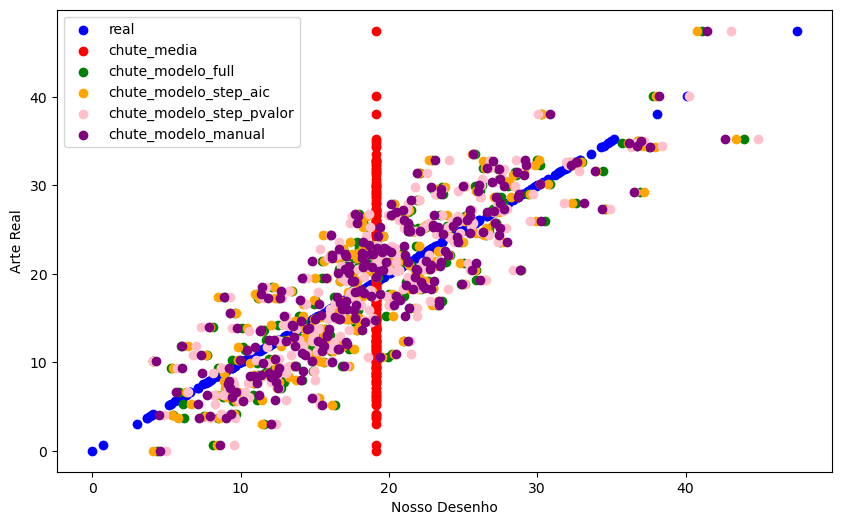

In [218]:
# definindo o tamanho da área do gráfico
plt.figure(figsize=(10, 6))
# adicionando a primeira camada que são nossos dados reais em azul
plt.scatter(df["bodyfat"], df["bodyfat"], color='blue', label='real')
# adicionando a camada do chute da média em vermelho
df["chute_media"] = df["bodyfat"].mean()
plt.scatter(df["chute_media"], df["bodyfat"], color='red', label='chute_media')
# adicionando a camada das nossas predições do modelo completo (sem nenhuma seleção) em verde
plt.scatter(tentativas["chute_modelo_full"], df["bodyfat"], color='green', label='chute_modelo_full')
# adicionando a camada das nossas predições do modelo stepwise pelo aic em laranja
plt.scatter(tentativas["chute_modelo_step_aic"], df["bodyfat"], color='orange', label='chute_modelo_step_aic')
# adicionando a camada das nossas predições do modelo stepwise por p-valor em pink
plt.scatter(tentativas["chute_modelo_step_pvalor"], df["bodyfat"], color='pink', label='chute_modelo_step_pvalor')
# adicionando a camada das nossas predições do modelo manual em roxo
plt.scatter(tentativas["chute_modelo_manual"], df["bodyfat"], color='purple', label='chute_modelo_manual')

plt.xlabel('Nosso Desenho')
plt.ylabel('Arte Real')
plt.legend()
plt.show()

<code style="color:purple">Comentários:</code>

Vamos seguir com a análise do modelo stepw_p

#### <code style="color:green">Comparar efeitos e variações</code>

- Analisar os nossos coeficientes observando o intervalo de confiança (apesar que já sai no summary)
- Vamos gerar os gráficos dos intervalos para facilitar a visualização

In [219]:
# pegando o intervalo de confiança dos coeficientes menos o B0
intervalo_confianca_forward = stepw_p.conf_int(alpha=0.05)[1:] 
intervalo_confianca_forward

,0,1
Abdomen,0.348553,0.435504
Weight,-0.406481,-0.191552
Wrist,-0.936001,-0.249481
Forearm,0.045326,0.327059


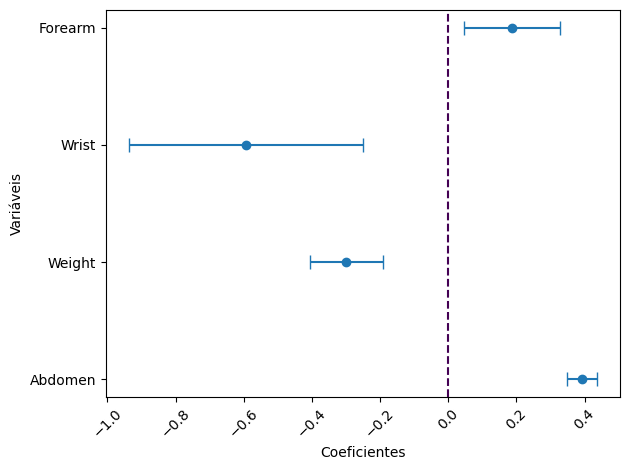

In [220]:
# criando o gráfico para o intervalo de confiança
fig, ax = plt.subplots() 

ax.errorbar(stepw_p.params.drop(['const']), # pegando os valores dos coeficientes e retirando a constante 
            stepw_p.params.drop(['const']).index,  # pegando os nomes dos coeficientes e retirando a constante
            xerr=[stepw_p.params.drop(['const']) - intervalo_confianca_forward[0], # criando as barras dos intervalos (limite inferior) 
                  intervalo_confianca_forward[1] - stepw_p.params.drop(['const'])], # criando as barras dos intervalos (limite superior)
            fmt='o', capsize=5)

ax.set_xlabel('Coeficientes') # adicionando o rótulo do eixo x
ax.set_ylabel('Variáveis') # adicionando o rótulo do eixo y
ax.axvline(x=0,linestyle='--', color = "#440154FF") # criando uma linha vertical no x = 0
plt.xticks(rotation=45) # adicionando uma rotação de 45 graus nos valores de x
plt.tight_layout()
plt.show()

<code style="color:purple">Comentários:</code>

- Quando algum intervalo corta a linha do 0 significa que o coeficiente não foi significativo.
- Note que todas, neste caso, foram significativas.

### <center>Validando o modelo

#### <code style="color:green">Análise de resíduos</code>

O resíduo nada mais é que o erro do nosso modelo, ou seja o quanto ele está errando ao tentar prever a variável dependente. Nesse caso, devemos analisar um conjunto de características para considerar o nosso modelo como um modelo robusto:
 
- Homogeneidade de variâncias: Vamos analisar o gráfico das predições sobre os resíduos. Se tiver algum tipo de padrão então as variâncias dos nossos resíduos são heterocedásticas, isto é, não homogêneas.

- Normalidade: Os resíduos precisam seguir uma distribuição normal com média igual a 0. Para isso vamos usar o QQ-Plot e teste estatístico

- Independência: Os resíduos não podem apresentar nenhum padrão conforme a variação de ychapeu

#### <code style="color:green">Qualidade dos Resíduos</code>

- **Omnibus**: O teste Omnibus avalia se os resíduos seguem uma distribuição normal, considerando a assimetria e a curtose dos resíduos. Um valor de p grande sugere que os resíduos podem ser normais. Este valor representa a estatística do teste.

- **Prob(Omnibus)**: Valor-p associado ao teste Omnibus, indicando a probabilidade de observar o resultado dado se a hipótese nula de distribuição normal for verdadeira. Idealmente, esperamos que os resíduos sejam normais para garantir que os pressupostos do modelo estejam corretos.

\begin{align*}
H_{0}: & \quad \text{Os resíduos são normais} \\
H_{1}: & \quad \text{Os resíduos não são normais}
\end{align*}

- **Skew**: Mede a assimetria da distribuição dos dados. Valores negativos de Skew indicam uma cauda mais longa à esquerda (distribuição assimétrica negativa), enquanto valores positivos indicam uma cauda mais longa à direita (distribuição assimétrica positiva).

- **Kurtosis**: Mede se a distribuição dos dados tem caudas mais pesadas ou mais leves em relação à distribuição normal. Valores de curtose maiores que 3 indicam que os dados têm caudas mais pesadas ou uma distribuição mais pontuda do que a normal.

- **Durbin-Watson**: Testa a autocorrelação nos resíduos de uma análise de regressão. O ideal é que os resíduos não sejam correlacionados entre si. Valores de Durbin-Watson próximos de 2 sugerem que não há autocorrelação nos resíduos. Valores próximos de 0 indicam autocorrelação positiva (os resíduos consecutivos estão correlacionados), enquanto valores próximos de 4 indicam autocorrelação negativa.

\begin{align*}
H_0: & \quad \text{Não há autocorrelação nos resíduos} \\
H_1: & \quad \text{Há autocorrelação nos resíduos}
\end{align*}

- **Jarque-Bera (JB)**: O teste de Jarque-Bera verifica se os resíduos têm assimetria e curtose compatíveis com uma distribuição normal, baseando-se em uma combinação dessas duas métricas.

- **Prob(JB)**: Valor-p para o teste Jarque-Bera, avaliando a probabilidade de observar tais estatísticas se a assimetria e a curtose corresponderem a uma distribuição normal.

\begin{align*}
H_0: & \quad \text{Os dados possuem assimetria e curtose que correspondem a uma distribuição normal} \\
H_1: & \quad \text{Os dados não possuem assimetria e curtose que correspondem a uma distribuição normal}
\end{align*}

- **Cond. No**: O Número de Condição avalia a multicolinearidade, ou seja, a correlação entre as variáveis independentes. Valores muito altos (geralmente acima de 30) indicam forte multicolinearidade, o que pode comprometer a estabilidade dos coeficientes estimados no modelo.


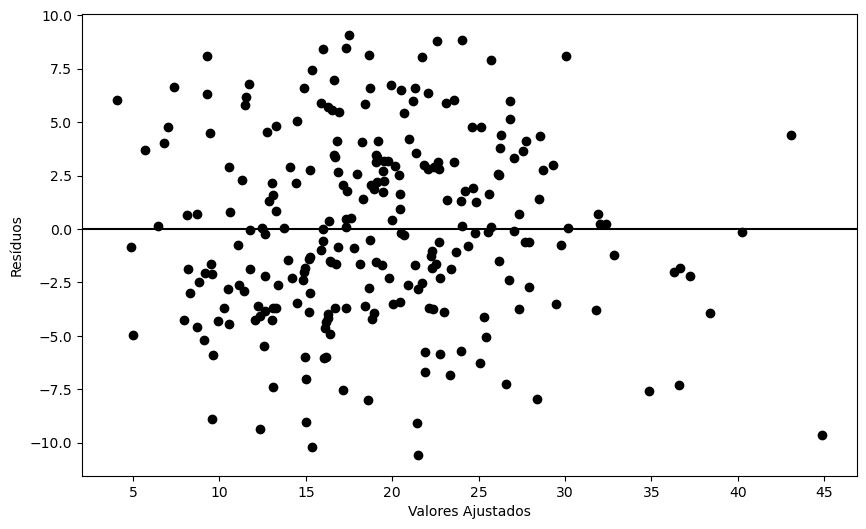

In [221]:
# criando gráfico de resíduos (resíduo x predito)
plt.figure(figsize=(10, 6))
plt.scatter(tentativas["chute_modelo_step_pvalor"],stepw_p.resid, color='black')
plt.axhline(y=0, color = 'black')
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.show()

#### <code style="color:purple">Observações:</code>

- Note que os resíduos não apresentam nenhum padrão, ou seja, demonstram independência.

#### <code style="color:green">Teste de Normalidade de Shapiro + QQ-plot + Histograma</code>

Gráficos são um pouco subjetivos. Dependendo do problema não dá para enxergar algo ou tirar uma conclusão. 
Testes estatísticos são mais confiáveis, portanto é melhor testar a normalidade e a homogeneidade de variâncias.

Normalidade (Shapiro-Wilk):

- $H_{0}:$ Os resíduos são normais
- $H_{1}:$ Os resíduos não são normais

In [222]:
# ele gera a estatística do teste e o p-valor
shapiro(stepw_p.resid) 

ShapiroResult(statistic=0.9893701076507568, pvalue=0.0612778477370739)

[]

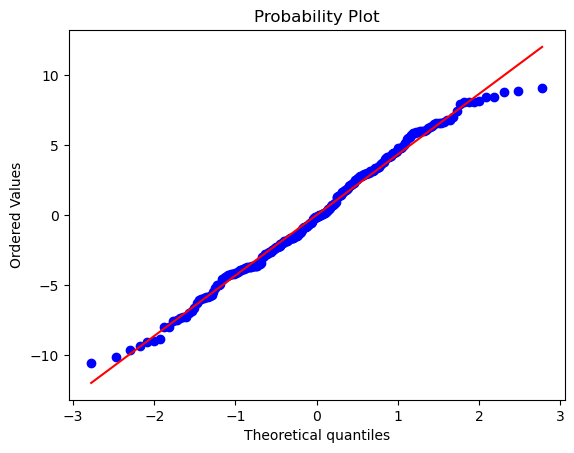

In [223]:
# qqplot 
stats.probplot(stepw_p.resid, dist="norm",plot=pylab)
pylab.plot()

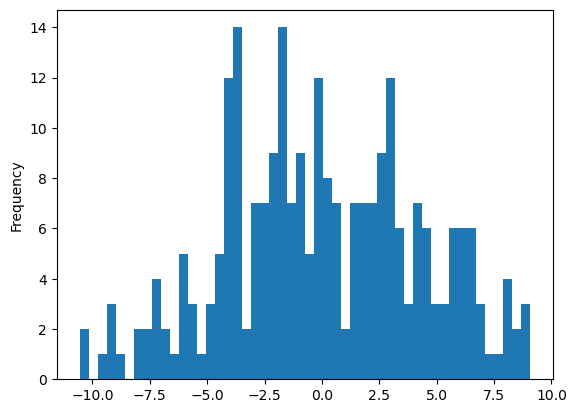

In [224]:
# visualizando o histograma
stepw_p.resid.plot(kind='hist', bins = 50)
plt.show()

#### <code style="color:purple">Observações:</code>

- Note que não rejeitamos $H_{0}$, logo os resíduos podem ser considerados como normais.
- Para que sejam considerados normais, os resíduos precisam seguir a linha em vermelho no qq-plot, o que pode indicar, novamente, normalidade.
- Pelo histograma, vemos um gráfico bem próximo da normalidade

#### <code style="color:green">Teste de Homogeneidade de Variância</code>

Validando o pressuposto de Homogeneidade de Variâncias através do teste de Breusch-Pagan:

- $H_{0}:$ Os resíduos possuem homogeneidade nas variâncias
- $H_{1}:$ Os resíduos não possuem homogeneidade nas variâncias

In [225]:
# Realizando o teste de Breusch-Pagan para verificar heterocedasticidade
# Passamos os resíduos do modelo (stepw_p.resid) e as variáveis explicativas (stepw_p.model.exog)
teste_bp = het_breuschpagan(stepw_p.resid, stepw_p.model.exog)
# Definindo os rótulos para os resultados do teste
rotulos = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
# Usando zip para associar cada rótulo ao seu respectivo resultado do teste e convertendo em um dicionário
resultado_bp = dict(zip(rotulos, teste_bp))
# Exibindo o p-valor do LM-Test
print(resultado_bp['LM-Test p-value'])

0.7128004749928467


#### <code style="color:purple">Observações:</code>

- Não rejeitamos $H_{0}$, logo as variâncias dos resíduos podem ser consideradas homogêneas.
- Sendo assim, esse modelo passou nos 4 pressupostos!

#### <code style="color:green">Multicolinearidade</code>

A multicolinearidade é um problema quando estamos tentando criar nosso modelo. Ela ocorre quando temos um conjunto de variáveis INDEPENDENTES que são altamente correlacionadas umas com as outras, o que gera um modelo com pouca confiabilidade. 

Vou analisar direto o VIF do modelo stepw_p:

In [226]:
# criando um dataframe vazio
vif = pd.DataFrame() 
# adicionando as colunas que você quer analisar (deixe a coluna const!)
vif["Variáveis"] =X_stepw_p.columns 
# para cada coluna, calcule o VIF
vif["VIF"] = [variance_inflation_factor(X_stepw_p.values, i) for i in range(len(X_stepw_p.columns))] 
vif

,Variáveis,VIF
0,const,701.380002
1,Abdomen,4.864380
2,Weight,7.040774
3,Wrist,2.273047
4,Forearm,1.793374


#### <code style="color:purple">Observações:</code>

- Normalmente, utiliza-se VIF entre 3 ou 5, ou seja, este modelo, por mais que tenha passado na análise de resíduo está com o dilema da multicolinearidade.

- Uma variável pode influenciar no VIF da outra, por isso sempre começar observando a matriz de correlação a fim de selecionar as variáveis que fazem mais sentido serem mantidas. Diminuindo assim a chance de ter VIF alto.

c:\Users\laris\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


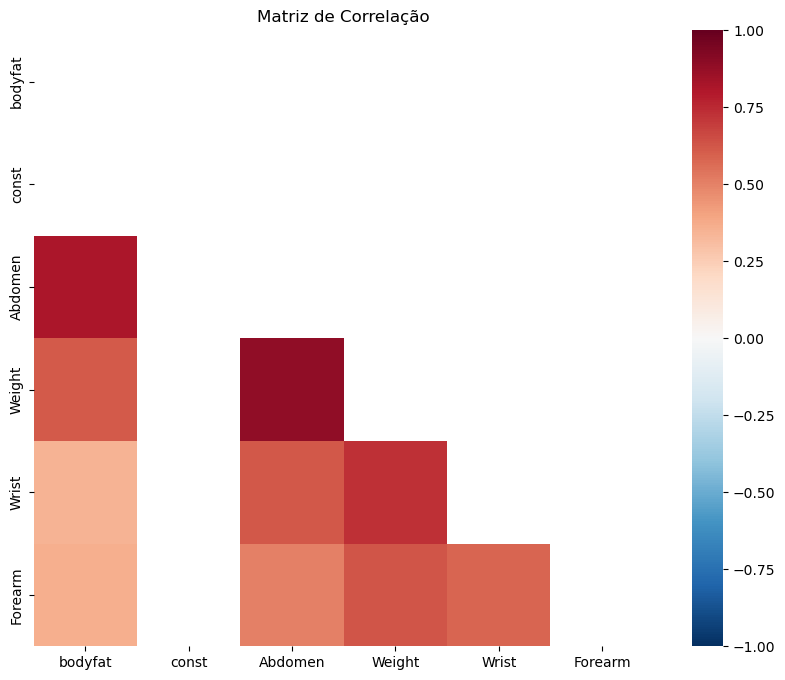

In [227]:
# vamos pegar da primeira até  a 14 coluna
corr_matrix = pd.concat([y,X_stepw_p], axis=1).corr(method='pearson')

# Criar a máscara para a parte superior da matriz, evitando redundância já que a matriz é simétrica
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) 

# Visualiza a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', center=0, vmax=1, vmin=-1, cmap="RdBu_r", annot_kws={"size": 10}, mask=mask)
plt.title('Matriz de Correlação')
plt.show()